# Index  <a name = "index"></a>
1. [Introduction](#intro)
2. [Overview of the Data](od)
3. [Maintenence Analysis](#ma)
4. [Telemetry and Labels Analysis](#tla)
    - [Analysing the different Machines](#tla_adm)
    - [Temporal Correlation](#tla_tc)
    - [Sensor to Sensor Correlation Analysis](#tla_ssca)
    - [Checking for diferrent Scales and Noise](#tla_cdsn)
    - [Maintenance and the Data](#tla_md)
5. [Smoothing for Analysis](#sa)

# Introduction <a name = "intro"></a>
[[go back to Index]](#index)

This Jupyter aims to analyze and understand the data we have available for the creation of a Bayesian network.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from src.bn_data_analysis import *

In [3]:
# Load raw data
telemetry = pd.read_csv("data/telemetry.csv")
labels = pd.read_csv("data/labels.csv")
maintenance = pd.read_csv("data/maintenance.csv")

# Overview of the Data <a name = "od"></a>
[[go back to Index]](#index)

**`Telemetry:`**

In [4]:
print("telemetry shape:", telemetry.shape)

telemetry shape: (103680, 11)


In [5]:
print("\nTelemetry – first 5 rows:")
print(telemetry.head())


Telemetry – first 5 rows:
             timestamp machine_id  spindle_temp  ambient_temp  vibration_rms  \
0  2025-01-01T00:00:00        M-A         73.96         24.36          0.871   
1  2025-01-01T00:05:00        M-A         53.38         22.87          0.536   
2  2025-01-01T00:10:00        M-A         58.12         24.59          0.455   
3  2025-01-01T00:15:00        M-A         58.08         23.05          0.680   
4  2025-01-01T00:20:00        M-A         55.37         24.28          0.663   

   coolant_flow  feed_rate  spindle_speed  load_pct  power_kw  tool_wear  
0         1.050        0.9           3600     0.294     3.193      0.000  
1         1.083        1.3            800     0.329     2.149      0.000  
2         1.025        0.9           1200     0.369     2.457      0.001  
3         0.977        0.7           1200     0.479     2.702      0.001  
4         1.072        1.1            800     0.328     2.148      0.001  


In [6]:
telemetry.dtypes

timestamp         object
machine_id        object
spindle_temp     float64
ambient_temp     float64
vibration_rms    float64
coolant_flow     float64
feed_rate        float64
spindle_speed      int64
load_pct         float64
power_kw         float64
tool_wear        float64
dtype: object

In [7]:
telemetry.isna().sum()

timestamp        0
machine_id       0
spindle_temp     0
ambient_temp     0
vibration_rms    0
coolant_flow     0
feed_rate        0
spindle_speed    0
load_pct         0
power_kw         0
tool_wear        0
dtype: int64

In [8]:
telemetry["machine_id"].value_counts()

machine_id
M-A    25920
M-B    25920
M-C    25920
M-D    25920
Name: count, dtype: int64

**`Labels:`**

In [9]:
print("labels shape:", labels.shape)

labels shape: (103680, 3)


In [10]:
print("\nLabels – first 5 rows:")
print(labels.head())


Labels – first 5 rows:
             timestamp machine_id  spindle_overheat
0  2025-01-01T00:00:00        M-A                 0
1  2025-01-01T00:05:00        M-A                 0
2  2025-01-01T00:10:00        M-A                 0
3  2025-01-01T00:15:00        M-A                 0
4  2025-01-01T00:20:00        M-A                 0


In [11]:
labels.dtypes

timestamp           object
machine_id          object
spindle_overheat     int64
dtype: object

In [12]:
labels.isna().sum()

timestamp           0
machine_id          0
spindle_overheat    0
dtype: int64

In [13]:
labels["machine_id"].value_counts()

machine_id
M-A    25920
M-B    25920
M-C    25920
M-D    25920
Name: count, dtype: int64

In [14]:
labels["spindle_overheat"].value_counts()

spindle_overheat
0    103680
Name: count, dtype: int64

**`Maintenance:`**

In [15]:
print("maintenance shape:", maintenance.shape)

maintenance shape: (23, 5)


In [16]:
print("\nMaintenance – first 5 rows:")
print(maintenance.head())


Maintenance – first 5 rows:
             timestamp machine_id      action_type  duration_h  success
0  2025-01-12T00:00:00        M-C     clean_filter         1.5        1
1  2025-01-13T00:00:00        M-A  replace_bearing         4.0        1
2  2025-01-14T00:00:00        M-B     clean_filter         1.5        1
3  2025-01-15T00:00:00        M-D  replace_bearing         4.0        1
4  2025-01-27T00:00:00        M-B     clean_filter         1.5        1


In [17]:
maintenance.dtypes

timestamp       object
machine_id      object
action_type     object
duration_h     float64
success          int64
dtype: object

In [18]:
maintenance.isna().sum()

timestamp      0
machine_id     0
action_type    0
duration_h     0
success        0
dtype: int64

In [19]:
maintenance["machine_id"].value_counts()

machine_id
M-C    6
M-A    6
M-B    6
M-D    5
Name: count, dtype: int64

> **Parse Timestamps and sorting**

In [20]:
"""
Converting the timestamp columns to datetime objects and sorting the dataframes by machine_id and timestamp.
"""

for df in [telemetry, labels, maintenance]:
    df["timestamp"] = pd.to_datetime(df["timestamp"])

telemetry = telemetry.sort_values(["machine_id", "timestamp"])
labels = labels.sort_values(["machine_id", "timestamp"])
maintenance = maintenance.sort_values(["machine_id", "timestamp"])

In [21]:
print("Telemetry time range:", telemetry["timestamp"].min(), "→", telemetry["timestamp"].max())
print("Labels time range:", labels["timestamp"].min(), "→", labels["timestamp"].max())
print("Maintenance time range:", maintenance["timestamp"].min(), "→", maintenance["timestamp"].max())

Telemetry time range: 2025-01-01 00:00:00 → 2025-03-31 23:55:00
Labels time range: 2025-01-01 00:00:00 → 2025-03-31 23:55:00
Maintenance time range: 2025-01-12 00:00:00 → 2025-03-28 00:00:00


Both the `telemetry` and `labels` datasets occur within the same time period. Through analysis of the datasets, it was possible to identify that we have data relating to 3 months:
- January (31 days);
- February (28 days);
- March (31 days);

Such that we have data for 4 machines (A, B, C, D) every 5 minutes.

The `maintenance` dataset indicates occurrences during those 3 months in which certain tasks needed to be performed on the machines to ensure their proper functioning.

# Maintenence Analysis <a name = "ma"></a>
[[go back to Index]](#index)

In [22]:
maintenance.head()

timestamp machine_id      action_type  duration_h  success
1  2025-01-13        M-A  replace_bearing         4.0        1
5  2025-01-28        M-A     clean_filter         1.5        1
8  2025-02-09        M-A     clean_filter         1.5        1
12 2025-02-23        M-A     clean_filter         1.5        1
17 2025-03-11        M-A  replace_bearing         4.0        1

In [23]:
maintenance.dtypes

timestamp      datetime64[ns]
machine_id             object
action_type            object
duration_h            float64
success                 int64
dtype: object

> **What type of maintenance actions do we have?**

In [24]:
maintenance["action_type"].value_counts()

action_type
clean_filter       13
replace_bearing     6
inspect_fan         3
refill_coolant      1
Name: count, dtype: int64

We have 4 different types of possible maintenance actions. The one that was needed the most was the `filter cleaning` each seems to need to be done regularly. Replacing the coolant, however, is an action that was only necessary once.

> **How many times does each macine need maintenence?**

In [25]:
maintenance["machine_id"].value_counts()

machine_id
M-A    6
M-B    6
M-C    6
M-D    5
Name: count, dtype: int64

In general, the machines seem to require maintenance approximately the same number of times, with no significant discrepancy in values.

> **Which type of action did each machine require?**

In [26]:
maintenance.groupby(["machine_id", "action_type"]).size()

machine_id  action_type    
M-A         clean_filter       4
            replace_bearing    2
M-B         clean_filter       4
            inspect_fan        2
M-C         clean_filter       2
            inspect_fan        1
            refill_coolant     1
            replace_bearing    2
M-D         clean_filter       3
            replace_bearing    2
dtype: int64

The types of actions performed on each machine vary, and it may be interesting to analyze the instances in which these actions were necessary.

> **Was maintenance always sucessful?**

In [27]:
maintenance["success"].value_counts()

success
1    23
Name: count, dtype: int64

> **How often did each machine require maintenance?**

In [28]:
df_sorted = maintenance.sort_values("timestamp")
df_sorted["diff_days"] = df_sorted.groupby("machine_id")["timestamp"].diff().dt.days
df_sorted.groupby("machine_id")["diff_days"].mean()

machine_id
M-A    13.8
M-B    14.0
M-C    15.0
M-D    15.5
Name: diff_days, dtype: float64

# Telemetry and Labels Analysis <a name = "tla"></a>
[[go back to Index]](#index)

> **Merging Telemetry with the Labels Dataset = merged_data**

In [29]:
merged_data = telemetry.merge(
    labels,
    on=["timestamp", "machine_id"],
    how="inner"
)

print("Merged shape:", merged_data.shape)
print("Unique (machine_id, timestamp) in telemetry:", telemetry[["machine_id","timestamp"]].drop_duplicates().shape)
print("Unique (machine_id, timestamp) in labels:", labels[["machine_id","timestamp"]].drop_duplicates().shape)

Merged shape: (103680, 12)
Unique (machine_id, timestamp) in telemetry: (103680, 2)
Unique (machine_id, timestamp) in labels: (103680, 2)


The merge was successful. This indicates that we now have a ranking for each event.

In [30]:
merged_data.head()

timestamp machine_id  spindle_temp  ambient_temp  vibration_rms  \
0 2025-01-01 00:00:00        M-A         73.96         24.36          0.871   
1 2025-01-01 00:05:00        M-A         53.38         22.87          0.536   
2 2025-01-01 00:10:00        M-A         58.12         24.59          0.455   
3 2025-01-01 00:15:00        M-A         58.08         23.05          0.680   
4 2025-01-01 00:20:00        M-A         55.37         24.28          0.663   

   coolant_flow  feed_rate  spindle_speed  load_pct  power_kw  tool_wear  \
0         1.050        0.9           3600     0.294     3.193      0.000   
1         1.083        1.3            800     0.329     2.149      0.000   
2         1.025        0.9           1200     0.369     2.457      0.001   
3         0.977        0.7           1200     0.479     2.702      0.001   
4         1.072        1.1            800     0.328     2.148      0.001   

   spindle_overheat  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [31]:
merged_data.dtypes

timestamp           datetime64[ns]
machine_id                  object
spindle_temp               float64
ambient_temp               float64
vibration_rms              float64
coolant_flow               float64
feed_rate                  float64
spindle_speed                int64
load_pct                   float64
power_kw                   float64
tool_wear                  float64
spindle_overheat             int64
dtype: object

In [32]:
merged_data.isna().sum()

timestamp           0
machine_id          0
spindle_temp        0
ambient_temp        0
vibration_rms       0
coolant_flow        0
feed_rate           0
spindle_speed       0
load_pct            0
power_kw            0
tool_wear           0
spindle_overheat    0
dtype: int64

## Analysing the different Machines <a name = "tla_adm"></a>
# Telemetry and Labels Analysis <a name = "tla"></a>
[[go back to Index]](#index)

**`spindle_temp:`**

In [33]:
merged_data.groupby("machine_id")[["spindle_temp"]].describe().round(3)

spindle_temp                                                  
                  count    mean    std    min    25%    50%    75%    max
machine_id                                                               
M-A             25920.0  68.224  6.401  50.70  63.37  67.28  72.61  87.85
M-B             25920.0  67.857  6.454  51.30  63.05  66.96  72.35  87.69
M-C             25920.0  68.150  6.454  50.08  63.33  67.26  72.61  87.26
M-D             25920.0  68.313  6.407  51.60  63.51  67.38  72.73  88.62

It is noticeable that, in general, the **spindle temperature values ​​are similar across all machines**, **never reaching a temperature higher than or equal to 89**. This information is relevant because we know that there are no cases of spindle overheat, and that all maintenance operations were successful. **This may indicate that when temperatures exceed 89, it may already be too late to request maintenance, resulting in spindle overheat**.

**`ambient_temp:`**

In [34]:
merged_data.groupby("machine_id")[["ambient_temp"]].describe().round(3)

ambient_temp                                                  
                  count    mean    std    min    25%    50%    75%    max
machine_id                                                               
M-A             25920.0  22.008  4.434  12.17  17.98  22.01  26.04  31.44
M-B             25920.0  22.002  4.427  12.57  17.98  21.99  26.01  31.57
M-C             25920.0  22.004  4.430  12.74  17.97  22.01  26.02  31.86
M-D             25920.0  21.993  4.427  12.32  17.98  21.98  25.99  31.39

Regarding ambient temperature, **the average values ​​are very similar**, although there is a **very slight variation in values** ​​that may be the result of the system heating and cooling over time. However, this information could be confirmed if there are high correlations between the variables for this feature.

**`vibration_ms:`**

In [35]:
merged_data.groupby("machine_id")[["vibration_rms"]].describe().round(3)

vibration_rms                                                 
                   count   mean    std    min    25%    50%    75%    max
machine_id                                                               
M-A              25920.0  0.968  0.189  0.396  0.844  0.957  1.097  1.485
M-B              25920.0  1.017  0.173  0.379  0.897  1.003  1.135  1.510
M-C              25920.0  0.982  0.187  0.364  0.861  0.972  1.108  1.518
M-D              25920.0  0.970  0.189  0.389  0.845  0.960  1.099  1.536

The **vibration values ​​are also very similar between the machines**, **although machine B presents slightly higher values ​​than the others**. When we analyze the maintenance procedures that were applied, we realize that the **only machine that did not have a Bearing Replaced was machine B**, which may justify the fact that it has slightly higher vibration values ​​than the others, since one of the ways to resolve High Vibration is through this maintenance action.

**`coolant_flow:`**

In [36]:
merged_data.groupby("machine_id")[["coolant_flow"]].describe().round(3)

coolant_flow                                                 
                  count   mean    std    min    25%    50%    75%    max
machine_id                                                              
M-A             25920.0  0.545  0.165  0.200  0.431  0.488  0.616  1.200
M-B             25920.0  0.544  0.165  0.226  0.431  0.487  0.616  1.200
M-C             25920.0  0.515  0.147  0.200  0.424  0.473  0.545  1.200
M-D             25920.0  0.528  0.156  0.222  0.427  0.479  0.567  1.171

Regarding coolant flow, **the values ​​for each machine are quite similar**, although there are some differences between them. We know that **lower coolant flow values ​​are usually resolved with maintenance actions such as filter cleaning**. Of course, there are other factors that influence coolant flow, but the most effective solution for resolving low values ​​in this metric is the one previously indicated. Analyzing the different machines, we concluded that **machines A and B had undergone more filter cleaning operations, which may justify the relatively higher coolant flow values**. **Machines C and D**, on the other hand, **show lower values**, which can be explained by the fact that **their filters were cleaned less frequently**.

**`feed_rate:`**

In [37]:
merged_data.groupby("machine_id")[["feed_rate"]].describe().round(3)

feed_rate                                       
               count   mean    std  min  25%  50%  75%  max
machine_id                                                 
M-A          25920.0  1.042  0.251  0.7  0.9  1.1  1.3  1.5
M-B          25920.0  1.039  0.252  0.7  0.9  1.1  1.3  1.5
M-C          25920.0  1.042  0.251  0.7  0.9  1.1  1.3  1.5
M-D          25920.0  1.040  0.250  0.7  0.9  1.1  1.3  1.5

Regarding the Feed Rate, **the values ​​are practically the same between the machines**.

**`spindle_speed:`**

In [38]:
merged_data.groupby("machine_id")[["spindle_speed"]].describe().round(3)

spindle_speed                                                    \
                   count      mean      std    min     25%     50%     75%   
machine_id                                                                   
M-A              25920.0  1845.077  897.995  800.0  1200.0  2000.0  2800.0   
M-B              25920.0  1843.580  893.430  800.0  1200.0  2000.0  2800.0   
M-C              25920.0  1853.333  894.856  800.0  1200.0  2000.0  2800.0   
M-D              25920.0  1857.346  900.166  800.0  1200.0  2000.0  2800.0   

                    
               max  
machine_id          
M-A         3600.0  
M-B         3600.0  
M-C         3600.0  
M-D         3600.0

In general, spindle speed values **​​are very similar**, with only minor variations.

**`load_pct:`**

In [39]:
merged_data.groupby("machine_id")[["load_pct"]].describe().round(3)

load_pct                                              
              count   mean    std   min    25%    50%    75%  max
machine_id                                                       
M-A         25920.0  0.514  0.203  0.05  0.357  0.504  0.668  1.0
M-B         25920.0  0.513  0.202  0.05  0.354  0.504  0.667  1.0
M-C         25920.0  0.512  0.201  0.05  0.356  0.502  0.665  1.0
M-D         25920.0  0.512  0.201  0.05  0.355  0.503  0.665  1.0

The values ​​detected per the machine in relation to Load PCT are **practically the same**.

**`power_kw:`**

In [40]:
merged_data.groupby("machine_id")[["power_kw"]].describe().round(3)

power_kw                                                 
              count   mean    std    min    25%    50%    75%    max
machine_id                                                          
M-A         25920.0  3.345  0.864  1.710  2.644  3.132  3.899  6.755
M-B         25920.0  3.341  0.858  1.742  2.641  3.138  3.886  6.881
M-C         25920.0  3.342  0.852  1.690  2.644  3.141  3.901  6.622
M-D         25920.0  3.347  0.860  1.811  2.645  3.143  3.897  6.692

The **differences** in Power kW values ​​between the machines **are very insignificant**, with **each consuming approximately the same amount of energy**.

**`tool_wear:`**

In [41]:
merged_data.groupby("machine_id")[["tool_wear"]].describe().round(3)

tool_wear                                       
               count   mean    std  min  25%  50%  75%  max
machine_id                                                 
M-A          25920.0  0.953  0.171  0.0  1.0  1.0  1.0  1.0
M-B          25920.0  0.953  0.170  0.0  1.0  1.0  1.0  1.0
M-C          25920.0  0.952  0.173  0.0  1.0  1.0  1.0  1.0
M-D          25920.0  0.953  0.172  0.0  1.0  1.0  1.0  1.0

Tool wear **is virtually the same across all machines**, with all starting at zero and eventually stabilizing at one.

**`overview of all features:`**

In [42]:
sensor_cols = ["spindle_temp", "ambient_temp", "vibration_rms", "coolant_flow", "feed_rate", "spindle_speed", "load_pct", "power_kw", "tool_wear"]

In [43]:
merged_data.groupby("machine_id")[sensor_cols].mean()

spindle_temp  ambient_temp  vibration_rms  coolant_flow  \
machine_id                                                            
M-A            68.224181     22.008073       0.968097      0.544610   
M-B            67.857067     22.001815       1.016815      0.543757   
M-C            68.150034     22.003779       0.981640      0.514911   
M-D            68.313410     21.992760       0.969621      0.527699   

            feed_rate  spindle_speed  load_pct  power_kw  tool_wear  
machine_id                                                           
M-A          1.041505    1845.077160  0.514367  3.345426   0.952802  
M-B          1.039375    1843.580247  0.513001  3.341299   0.953330  
M-C          1.041698    1853.333333  0.511787  3.342241   0.952023  
M-D          1.039606    1857.345679  0.511855  3.346634   0.952511

Analysing feature: spindle_temp


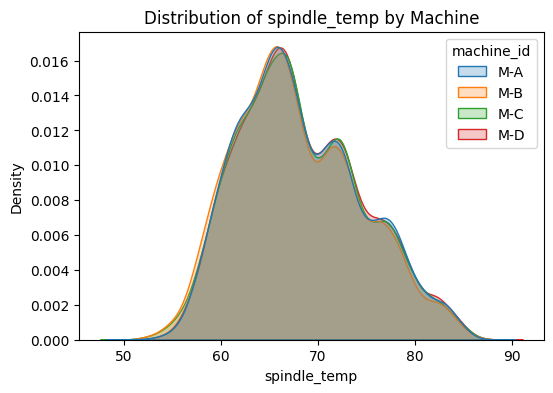

Analysing feature: ambient_temp


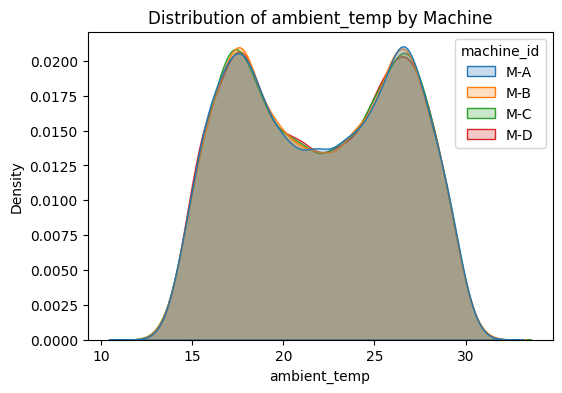

Analysing feature: vibration_rms


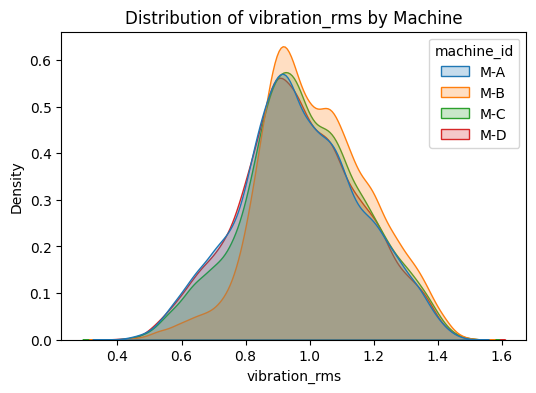

Analysing feature: coolant_flow


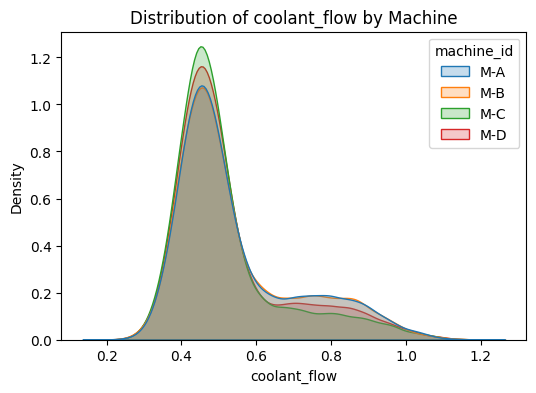

Analysing feature: feed_rate


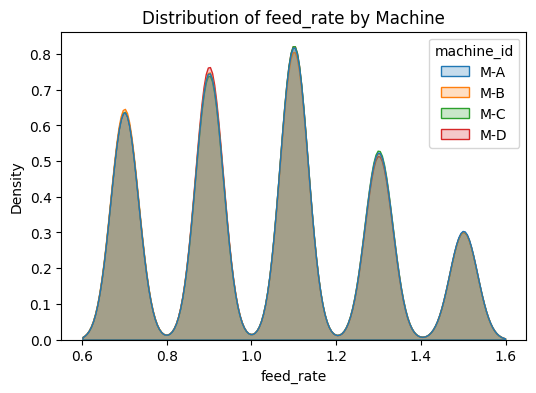

Analysing feature: spindle_speed


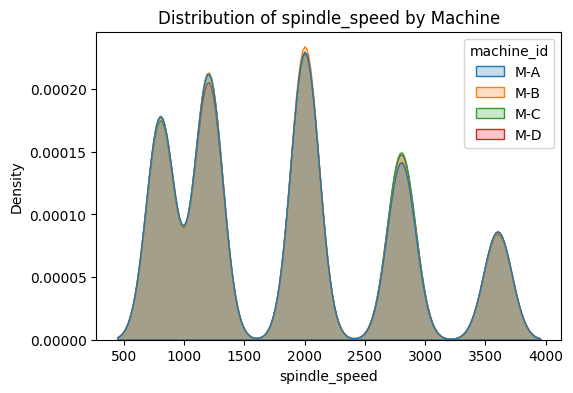

Analysing feature: load_pct


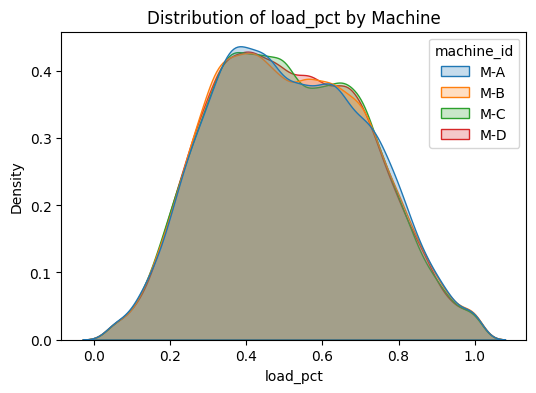

Analysing feature: power_kw


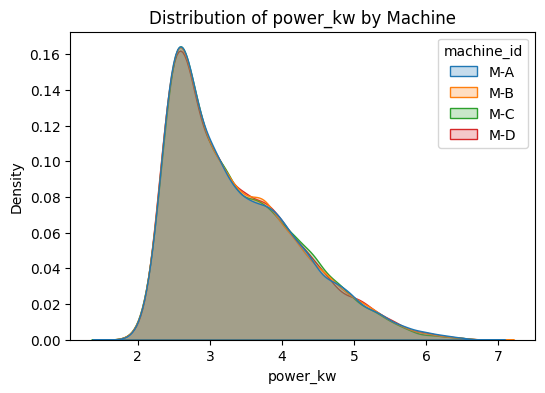

Analysing feature: tool_wear


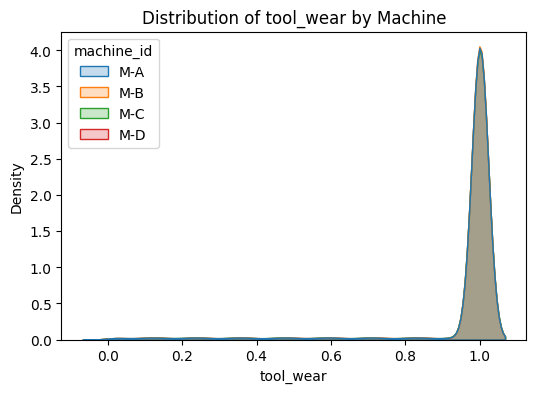

In [44]:
for col in sensor_cols:
    print("Analysing feature:", col)
    
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=merged_data, x=col, hue="machine_id", fill=True)
    plt.title(f"Distribution of {col} by Machine")
    plt.show()

Through the analysis of these graphs and tabels, we can see that on average:
- The machines appear to have similarly calibrated sensors.
- The values ​​occupy the same ranges.
- The distributions are practically identical.

This allows us to conclude that there is no machine with absurdly different static behaviors. Therefore, we are dealing with values ​​that are in the same "universe." However, it is also important to analyze whether there is any kind of similar temporal pattern, since we are only seeing the average behavior of the machines.

Since the machines do not show significant differences in terms of mean, dispersion, and quantiles for each metric, **we conclude that there is no strong evidence that the behavior of the sensors depends on the machine**. This suggests that **the four machines follow the same data generation process**, so in the Bayesian Network, **we can treat the machines as equivalent**.

Como as distribuições de telemetria são praticamente iguais entre máquinas e o label spindle_overheat é sempre 0, concluímos que, neste conjunto de dados, o machine_id não acrescenta informação relevante ao modelo. Para manter a BN mais simples e robusta, optámos por não incluir machine_id como nó explícito.

## Temporal Correlation <a name = "tla_tc"></a>
[[go back to Index]](#index)

The telemetry data provided in the problem statement are time series: for each machine there are successive measurements, collected at equally spaced instants. Before defining the final structure of our Bayesian network, it is important to understand to what extent these measurements depend on the past. In particular, we want to answer two questions:

- **Is the temporal dynamics of the sensors relevant for diagnosis?** If the value at a given instant already summarizes the recent history well, a static Bayesian network may be sufficient. Otherwise, a dynamic approach (Dynamic Bayesian Network) could be justified.
- **Do the four machines have different temporal behaviors?** If each machine had its own "memory" or evolution, we might have to explicitly model `machine_id` on the network.

To study these issues, we calculated the autocorrelation of the telemetry variables. **Autocorrelation measures the degree of dependence between the value of a variable at a given time `t` and its value at previous times `t - k` (lags)**. Values ​​close to 1 indicate that the series is very persistent (the current value is very similar to that of the past) and values ​​close to 0 indicate that the series is more volatile.

Specifically, for each machine and each sensor, we calculated the autocorrelation for different time lags (1, 6, and 12 steps, corresponding approximately to 5, 30, and 60 minutes).

This analysis allows us, on the one hand, to characterize the temporal memory of each variable and, on the other hand, to verify again if there is any significant difference between the machines. Based on these results, we subsequently **decide whether it is justifiable to treat each observation as an independent "snapshot" in a static Bayesian network**, **or whether it is necessary to introduce explicit dependencies between consecutive instants in a dynamic model**.

In [45]:
# Lags = number of "skiped" rows. 1 = 5 min, 6 = 30 min, 12 = 1 hour
autocorr_df = autocorr_by_machine(merged_data, sensor_cols, lags=(1, 6, 12))

> **Autocorrelation Per Machine:**

In [46]:
print("\n=== Autocorrelation per variable/lag/machine ===")
print(
    autocorr_df
    .pivot_table(index=["variable", "lag"], columns="machine_id", values="autocorr")
)


=== Autocorrelation per variable/lag/machine ===
machine_id              M-A       M-B       M-C       M-D
variable      lag                                        
ambient_temp  1    0.974803  0.974372  0.974264  0.974343
              6    0.967105  0.966670  0.966652  0.966132
              12   0.943246  0.942714  0.942942  0.942835
coolant_flow  1    0.868385  0.865714  0.832505  0.853915
              6    0.864235  0.861219  0.830616  0.850879
              12   0.861957  0.857621  0.828293  0.845203
feed_rate     1    0.218409  0.226183  0.217116  0.202841
              6    0.196384  0.206691  0.206684  0.202545
              12   0.184634  0.180329  0.182765  0.186195
load_pct      1    0.539688  0.539108  0.534956  0.538074
              6    0.499175  0.497494  0.500302  0.500379
              12   0.455032  0.451315  0.457023  0.454611
power_kw      1    0.434712  0.431555  0.444839  0.432972
              6    0.406163  0.395474  0.411151  0.410210
              12   0.3

For each variable and each lag, the autocorrelation values ​​in M-A, M-B, M-C, and M-D **are practically the same**, that is:
- the four machines have the same type of temporal dynamics;
- there is no machine that "forgets" faster, another that oscillates more, etc.

**This further reinforces the conclusion previously drawn that the machines are practically clones in terms of sensor behavior.**

> **Autocorrelation Overview:**

In [47]:
# See in a compact way the autocorrelation results: mean by variable/lag and also by machine
print("\n=== Mean Autocorrelation per variable/lag (mean over machines) ===")
print(
    autocorr_df
    .groupby(["variable", "lag"])["autocorr"]
    .mean()
    .unstack("lag")
)


=== Mean Autocorrelation per variable/lag (mean over machines) ===
lag                  1         6         12
variable                                   
ambient_temp   0.974445  0.966640  0.942934
coolant_flow   0.855130  0.851737  0.848268
feed_rate      0.216137  0.203076  0.183481
load_pct       0.537956  0.499338  0.454495
power_kw       0.436020  0.405749  0.366539
spindle_speed  0.200163  0.186731  0.165087
spindle_temp   0.325538  0.308383  0.282394
tool_wear      1.000000  0.999996  0.999987
vibration_rms  0.407115  0.400191  0.387279


For each variable we are effectively asking: “How similar is the current value to the value 5/30/60 minutes ago?”

Values close to 1 indicate a very persistent, slowly changing process while values close to 0 indicate a fast-changing, almost memory-less process.

**High Autocorrelation:**
- **`Ambient Temperature:`** This is an extremely high and slowly decaying autocorrelation. The ambient temperature around the machines changes very gradually. Knowing the value an hour ago almost completely determines the value now. **In practice, the current reading already encodes the recent history of ambient conditions**. **Modelling explicit temporal links for this variable in a Bayesian network would add little information beyond the current snapshot**.
- **`Tool Wear:`** is effectively a deterministic, monotonically increasing signal between maintenance events. The value one hour ago is almost perfectly linearly related to the value now. This is exactly what we expect from a cumulative wear indicator. **It also means that introducing temporal nodes for tool wear would be redundant**. The current wear level already represents the cumulative effect of all past operation since the last maintenance.
- **`Coolant Flow:`** Again we observe very strong and almost flat autocorrelation over an hour. The coolant flow tends to remain at a fairly stable operating level unless there is an intervention or a fault. As with ambient temperature, the **present value is an excellent summary of the last hour of behaviour**. From a modelling perspective, **this supports treating coolant_flow at time t as sufficient**, without needing explicit parents from earlier time steps.

**Moderate Autocorrelation:**
- **`Load PCT:`** Here we see moderate autocorrelation that decays slowly over time. The load at a given instant is partly determined by the ongoing job (program, material, etc.), so similar loads persist over several time steps, but it is still free to change as operations change. This is typical “short-memory” industrial behaviour. **Knowing recent history does help somewhat, but the current reading still carries the bulk of the information about the instantaneous stress on the spindle**.
- **`Vibration RMS:`** Shows a moderate but not extreme degree of persistence. Levels tend to remain similar within the same operational regime, but exhibit more variability than the very slow variables above. The important point is that the autocorrelation stabilises around ~0.4 even at longer lags, which again **suggests that the present vibration level is a good indicator of the current mechanical state**, and recent history provides only incremental refinement.
- **`Power KW:`** Exhibits moderate autocorrelation, very similar to load_pct and vibration_rms. This reflects that power follows the mechanical load and the current operation, with some persistence but no long-range memory. Again, **the current value is an adequate summary of the machine’s present energy demand**.

**Low Autocorrelation:**
- **`Spindle Temperature:`** Retains some memory of the recent past (the spindle does not cool or heat instantaneously), **but autocorrelation levels are clearly lower** than for ambient and coolant flow. **The decay over lags indicates that temperature reacts on a shorter time scale** to changes in cooling and load. For diagnostic purposes, however, **the instantaneous spindle_temp is precisely what we care about** (e.g. detecting “high spindle temperature” as a symptom). Adding explicit parents from previous time steps would complicate the network without a clear gain.
- **`Spindle Speed and Feed Rate:`** These are the least persistent variables. **They change rapidly according to the programmed machining operations, with relatively weak dependence on the previous time step**. This means the historical values add little predictive power beyond knowing the current speed and feed, which are already included as instantaneous nodes in the network.

**Conclusion:**
All telemetry variables exhibit some degree of temporal dependence, which is expected in an industrial setting. However, for most variables the current value already captures the relevant state of the system:
- Slow variables (ambient_temp, coolant_flow, tool_wear) are so persistent that the present reading is effectively a compressed summary of the last hour.
- Faster variables (spindle_temp, vibration_rms, load_pct, power_kw, feed_rate, spindle_speed) have only moderate or low autocorrelation, so their diagnostic value is dominated by the current measurement rather than detailed history.

The purpose of the Bayesian network in this project is to reason about the current health state of the spindle cooling subsystem (causes → symptoms → present telemetry). Given the autocorrelation results, adding nodes for previous time steps would significantly increase the number of nodes and conditional probability tables, and mainly encode persistence that is already implicitly represented by the current sensor readings.

**This supports the choice of a static Bayesian Network.** We can legitimately treat each time stamp as a snapshot of the system, use the instantaneous telemetry as evidence nodes, and model causal relations at a single time slice. Temporal behaviour is implicitly reflected in the values of slow-moving variables, without the complexity of explicit time-indexed nodes.

## Sensor to Sensor Correlation Analysis <a name = "tla_ssca"></a>
[[go back to Index]](#index)

Before fixing the structure of the Bayesian Network, it is important to understand how the different telemetry sensors relate to one another. In particular, we want to know whether some sensors are highly correlated and therefore effectively measuring the same underlying phenomenon. This step will allow us to determine:
- **`Redundancy and Dimensionality:`** If two sensors are almost perfectly correlated, they carry very similar information. Modelling both as independent parents of other nodes increases the size of the conditional probability tables without adding much new information. Identifying such redundancies allows us to keep only one of the sensors as a direct parent in the network, or model them in a hierarchical way (one causal parent, the other as a consequence),
which results in a simpler and more robust BN.
- **`Understanding functional groups of variables:`** Patterns of correlation reveal natural groups of sensors which help us design a structure that respects the physical relationships in the system.
- **`Avoiding confusing or unstable parameter estimates:`** When highly correlated sensors are all used as parents of the same child node, the BN ends up with large CPTs and parameters that are harder to interpret and to estimate reliably from data. By detecting strong correlations in advance, we can deliberately choose a smaller, non-redundant set of parents, which improves interpretability and reduces the risk of overfitting.

For these reasons, we compute correlation matrices between all telemetry variables (both over all machines combined and separately per machine) and highlight sensor pairs with very high correlation. These results then inform which sensors we treat as primary causes, which we treat as consequences, and which we may safely omit from the BN structure.

> **Correlation per Machine**

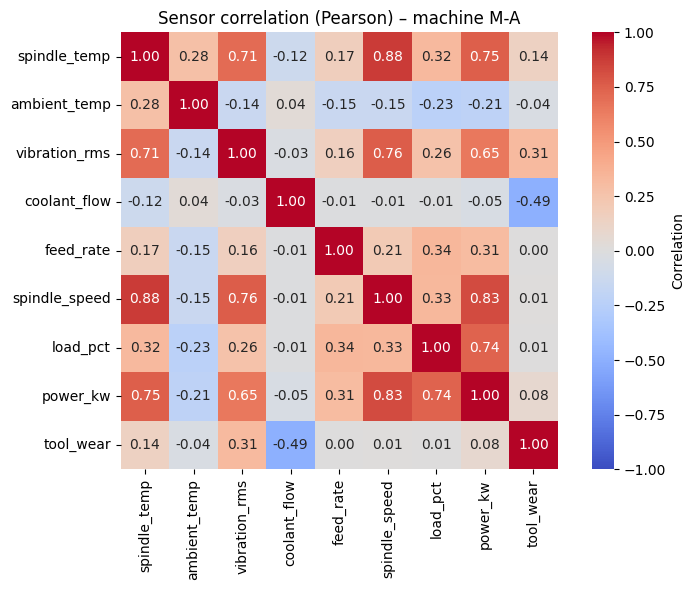


=== Strongly correlated pairs (|corr| ≥ 0.75) – machine M-A ===
         var1          var2     corr
 spindle_temp spindle_speed 0.878194
spindle_speed      power_kw 0.826081
vibration_rms spindle_speed 0.763021
 spindle_temp      power_kw 0.751425


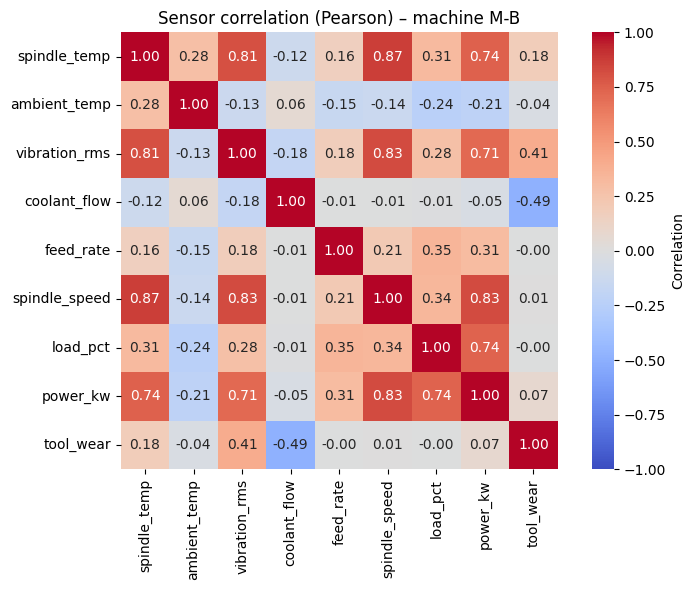


=== Strongly correlated pairs (|corr| ≥ 0.75) – machine M-B ===
         var1          var2     corr
 spindle_temp spindle_speed 0.868930
vibration_rms spindle_speed 0.827147
spindle_speed      power_kw 0.825440
 spindle_temp vibration_rms 0.810231


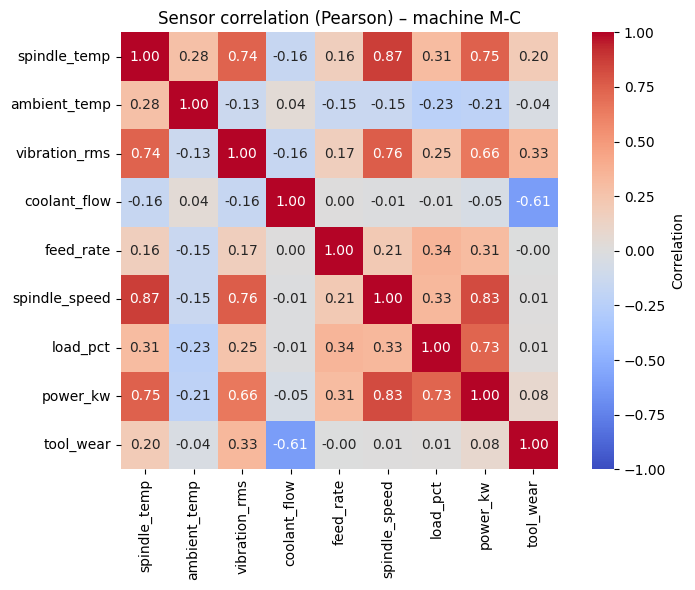


=== Strongly correlated pairs (|corr| ≥ 0.75) – machine M-C ===
         var1          var2     corr
 spindle_temp spindle_speed 0.868090
spindle_speed      power_kw 0.825523
vibration_rms spindle_speed 0.764631


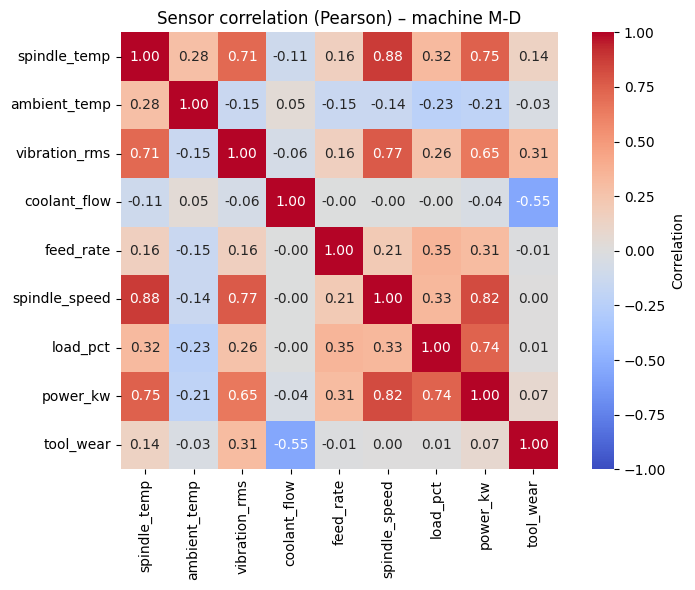


=== Strongly correlated pairs (|corr| ≥ 0.75) – machine M-D ===
         var1          var2     corr
 spindle_temp spindle_speed 0.879240
spindle_speed      power_kw 0.823140
vibration_rms spindle_speed 0.767925


In [48]:
machines = merged_data["machine_id"].unique()
threshold = 0.75

for mid in machines:
    df_m = merged_data[merged_data["machine_id"] == mid]

    corr_m = df_m[sensor_cols].corr(method="pearson")

    # --- Heatmap plot (com valores na matriz) ---
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_m,
        vmin=-1, vmax=1,
        cmap="coolwarm",
        annot=True, fmt=".2f",
        square=True,
        cbar_kws={"label": "Correlation"}
    )
    plt.title(f"Sensor correlation (Pearson) – machine {mid}")
    plt.tight_layout()
    plt.show()

    # --- Strong pairs for this machine ---
    strong_pairs = list_strong_pairs(corr_m, threshold=threshold)
    print(f"\n=== Strongly correlated pairs (|corr| ≥ {threshold}) – machine {mid} ===")
    if strong_pairs.empty:
        print("No pairs above threshold.")
    else:
        print(strong_pairs.to_string(index=False))

Across all four machines **the correlation structure is remarkably consistent**. The same groups of sensors are strongly related, and the numerical values are very similar in each heatmap. **The machines do not only look similar in terms of means and standard deviations, but, they also share essentially the same dependency structure between sensors**. This is another strong argument for treating them as instances of the same underlying process in the Bayesian Network.

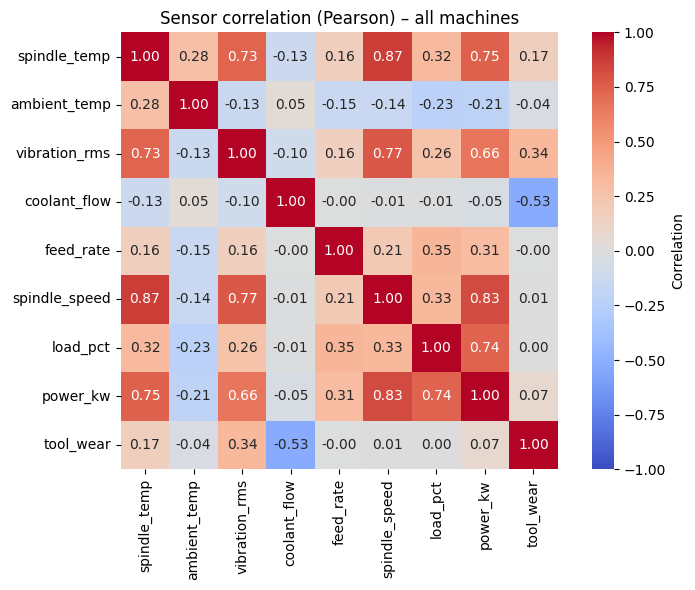


=== Strongly correlated pairs (|corr| ≥ 0.75) – all machines ===
         var1          var2     corr
 spindle_temp spindle_speed 0.873379
spindle_speed      power_kw 0.825025
vibration_rms spindle_speed 0.774418


In [49]:
# --- Correlation over all machines ---
corr_all = merged_data[sensor_cols].corr(method="pearson")

# Heatmap com valores
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_all,
    vmin=-1, vmax=1,
    cmap="coolwarm",
    annot=True, fmt=".2f",
    square=True,
    cbar_kws={"label": "Correlation"}
)
plt.title("Sensor correlation (Pearson) – all machines")
plt.tight_layout()
plt.show()

# Strong pairs (potential redundancy)
strong_pairs_all = list_strong_pairs(corr_all, threshold=threshold)
print(f"\n=== Strongly correlated pairs (|corr| ≥ {threshold}) – all machines ===")
if strong_pairs_all.empty:
    print("No pairs above threshold.")
else:
    print(strong_pairs_all.to_string(index=False))

We can see that there are some strong correlations (threshold of 0.75), which gives us a **clear operating-regime cluster centred on `spindle_speed`**. When the spindle runs faster, power consumption increases, spindle temperature rises and vibration tends to increase.

Other notable, but slightly below-threshold, correlations are:
- load_pct – power_kw: 0.74
- spindle_temp – vibration_rms: 0.73

These confirm that **load and power belong to the same mechanical-effort group**, and that high speed/load tends to produce both higher vibration and higher spindle temperature.

**Crucially, none of the correlations is close to 1.0, so no sensor is a pure duplicate of another. They share information but are not identical, therefore our sensors are distinct enough that each one adds unique information to the Bayesian Network.**

The combined matrix also confirms three relatively independent “axes”:

- `Cooling subsystem:` coolant_flow has very low correlation with most other sensors, apart from a moderate negative link with tool_wear (≈ −0.53). This supports modelling coolant_flow as its own causal factor for thermal behaviour, not as a side effect of speed or load.
- `Environment:` ambient_temp shows only small correlations (around ±0.2–0.3), which is consistent with its role as a slow background condition that slightly shifts temperatures but does not track the machining regime.
- `Tool condition:` tool_wear is only modestly correlated with vibration_rms and negatively with coolant_flow, which suggests it is best represented as a separate health-state node rather than merged with the operating-regime cluster.

## Checking for diferrent Scales and Noise <a name = "tla_cdsn"></a>
[[go back to Index]](#index)

Bayesian Networks  require discretization, that is, binning values into `Low`, `Medium` or `High`, for example. So checking the scales of our features, is vital.

For example:

- If we plot `vibration_rms` (0-5 range) on the same chart as `spindle_speed` (0-5000 range), the vibration data will appear as a flat line at zero. This creates issues if we try to normalize data globally.

- Raw sensors have "jitter". If we discretize raw data, a stable machine might flicker between "Normal" and "Warning" bins just because of sensor noise (e.g., 59.9°C vs 60.1°C). This causes unstable probabilities in the BN.

Therefore, we will plot both `spindle_temp` and `vibration_rms` simulataniously so we can make conclusions on the differences of scales.

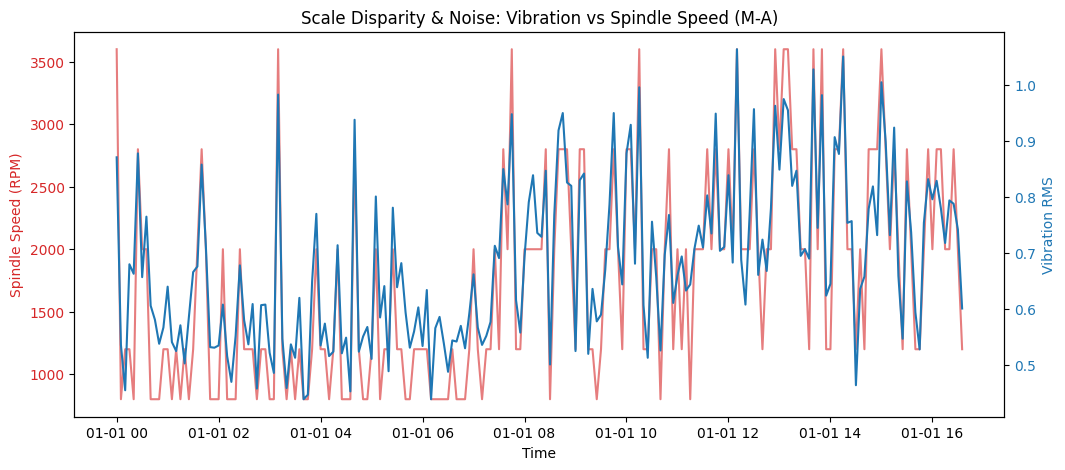

In [50]:
# 1. Select a single machine to visualize (e.g., the first one found)
target_machine = merged_data['machine_id'].unique()[0]
df_single = merged_data[merged_data['machine_id'] == target_machine].sort_values('timestamp')

# 2. Setup the plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Spindle Speed (Large Scale)
color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Spindle Speed (RPM)', color=color)
# Plot the first 200 points of THIS specific machine
ax1.plot(df_single['timestamp'][:200], df_single['spindle_speed'][:200], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot Vibration (Small Scale)
color = 'tab:blue'
ax2.set_ylabel('Vibration RMS', color=color)
ax2.plot(df_single['timestamp'][:200], df_single['vibration_rms'][:200], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title(f'Scale Disparity & Noise: Vibration vs Spindle Speed ({target_machine})')
plt.show()

**Conclusions**:

- `Scale Disparity is Real:` One sensor is in the thousands (0-4000), the other is tiny (0-1.5). This proves we must normalize or discretize carefully. Otherwise, the model might ignore the small numbers.

- `Noise is High:` The blue line is extremely jagged. This proves we cannot use raw data. We must apply smoothing (like a rolling average) before building the Bayesian Network, or the model will panic at every random micro-spike.

## Maintenance and the Data <a name = "tla_md"></a>
[[go back to Index]](#index)

Because **our dataset contains no recorded spindle-overheat events**, we cannot directly learn how the system behaves “right before” a failure. What we do have, however, is a detailed log of maintenance actions (bearing replacement, filter cleaning, fan inspection, etc.). In practice, these actions are triggered when the machine is suspected to be in a degraded or risky state, and they usually restore the system to a healthier condition.

Analysing how telemetry signals behave before and after maintenance is therefore crucial for several reasons:
- **`Proxy for fault conditions:`** When a component is replaced or a filter is cleaned, it is typically because the underlying cause was present or imminent. By comparing sensor values in a window before and after the intervention, we obtain an indirect view of how the machine behaves near “would-be faults”, even though the actual overheat label never becomes 1;
- **`Validation of the causal model:`** Our Bayesian Network draft assumes links such as “CloggedFilter → LowCoolantFlow” and “BearingWearHigh → HighVibration”. If, in the data, we observe that coolant flow systematically increases after filter-cleaning, and vibration systematically decreases after bearing replacement, this provides empirical support for those causal relations and helps justify the network structure.
- **`Calibration of Symptom thresholds and Conditional Probabilities:`** The magnitude of the change before/after maintenance tells us how “abnormal” coolant flow or vibration typically are when action is taken and how large of an improvement we can expect from a given procedure. This information can be used to set thresholds for high/low states and to calibrate conditional probability tables in the BN.
- **`Understanding Maintenance Strategy:`** If sensor values are clearly degraded before an action and normal afterwards, maintenance appears largely reactive. If values are already near-normal, actions may be more preventive or calendar-based. This distinction influences how we interpret maintenance in the BN: as a response to symptoms, as an independent decision, or a mixture of both.

**`All Maintenance Actions per Machine`**

===== Machine A =====


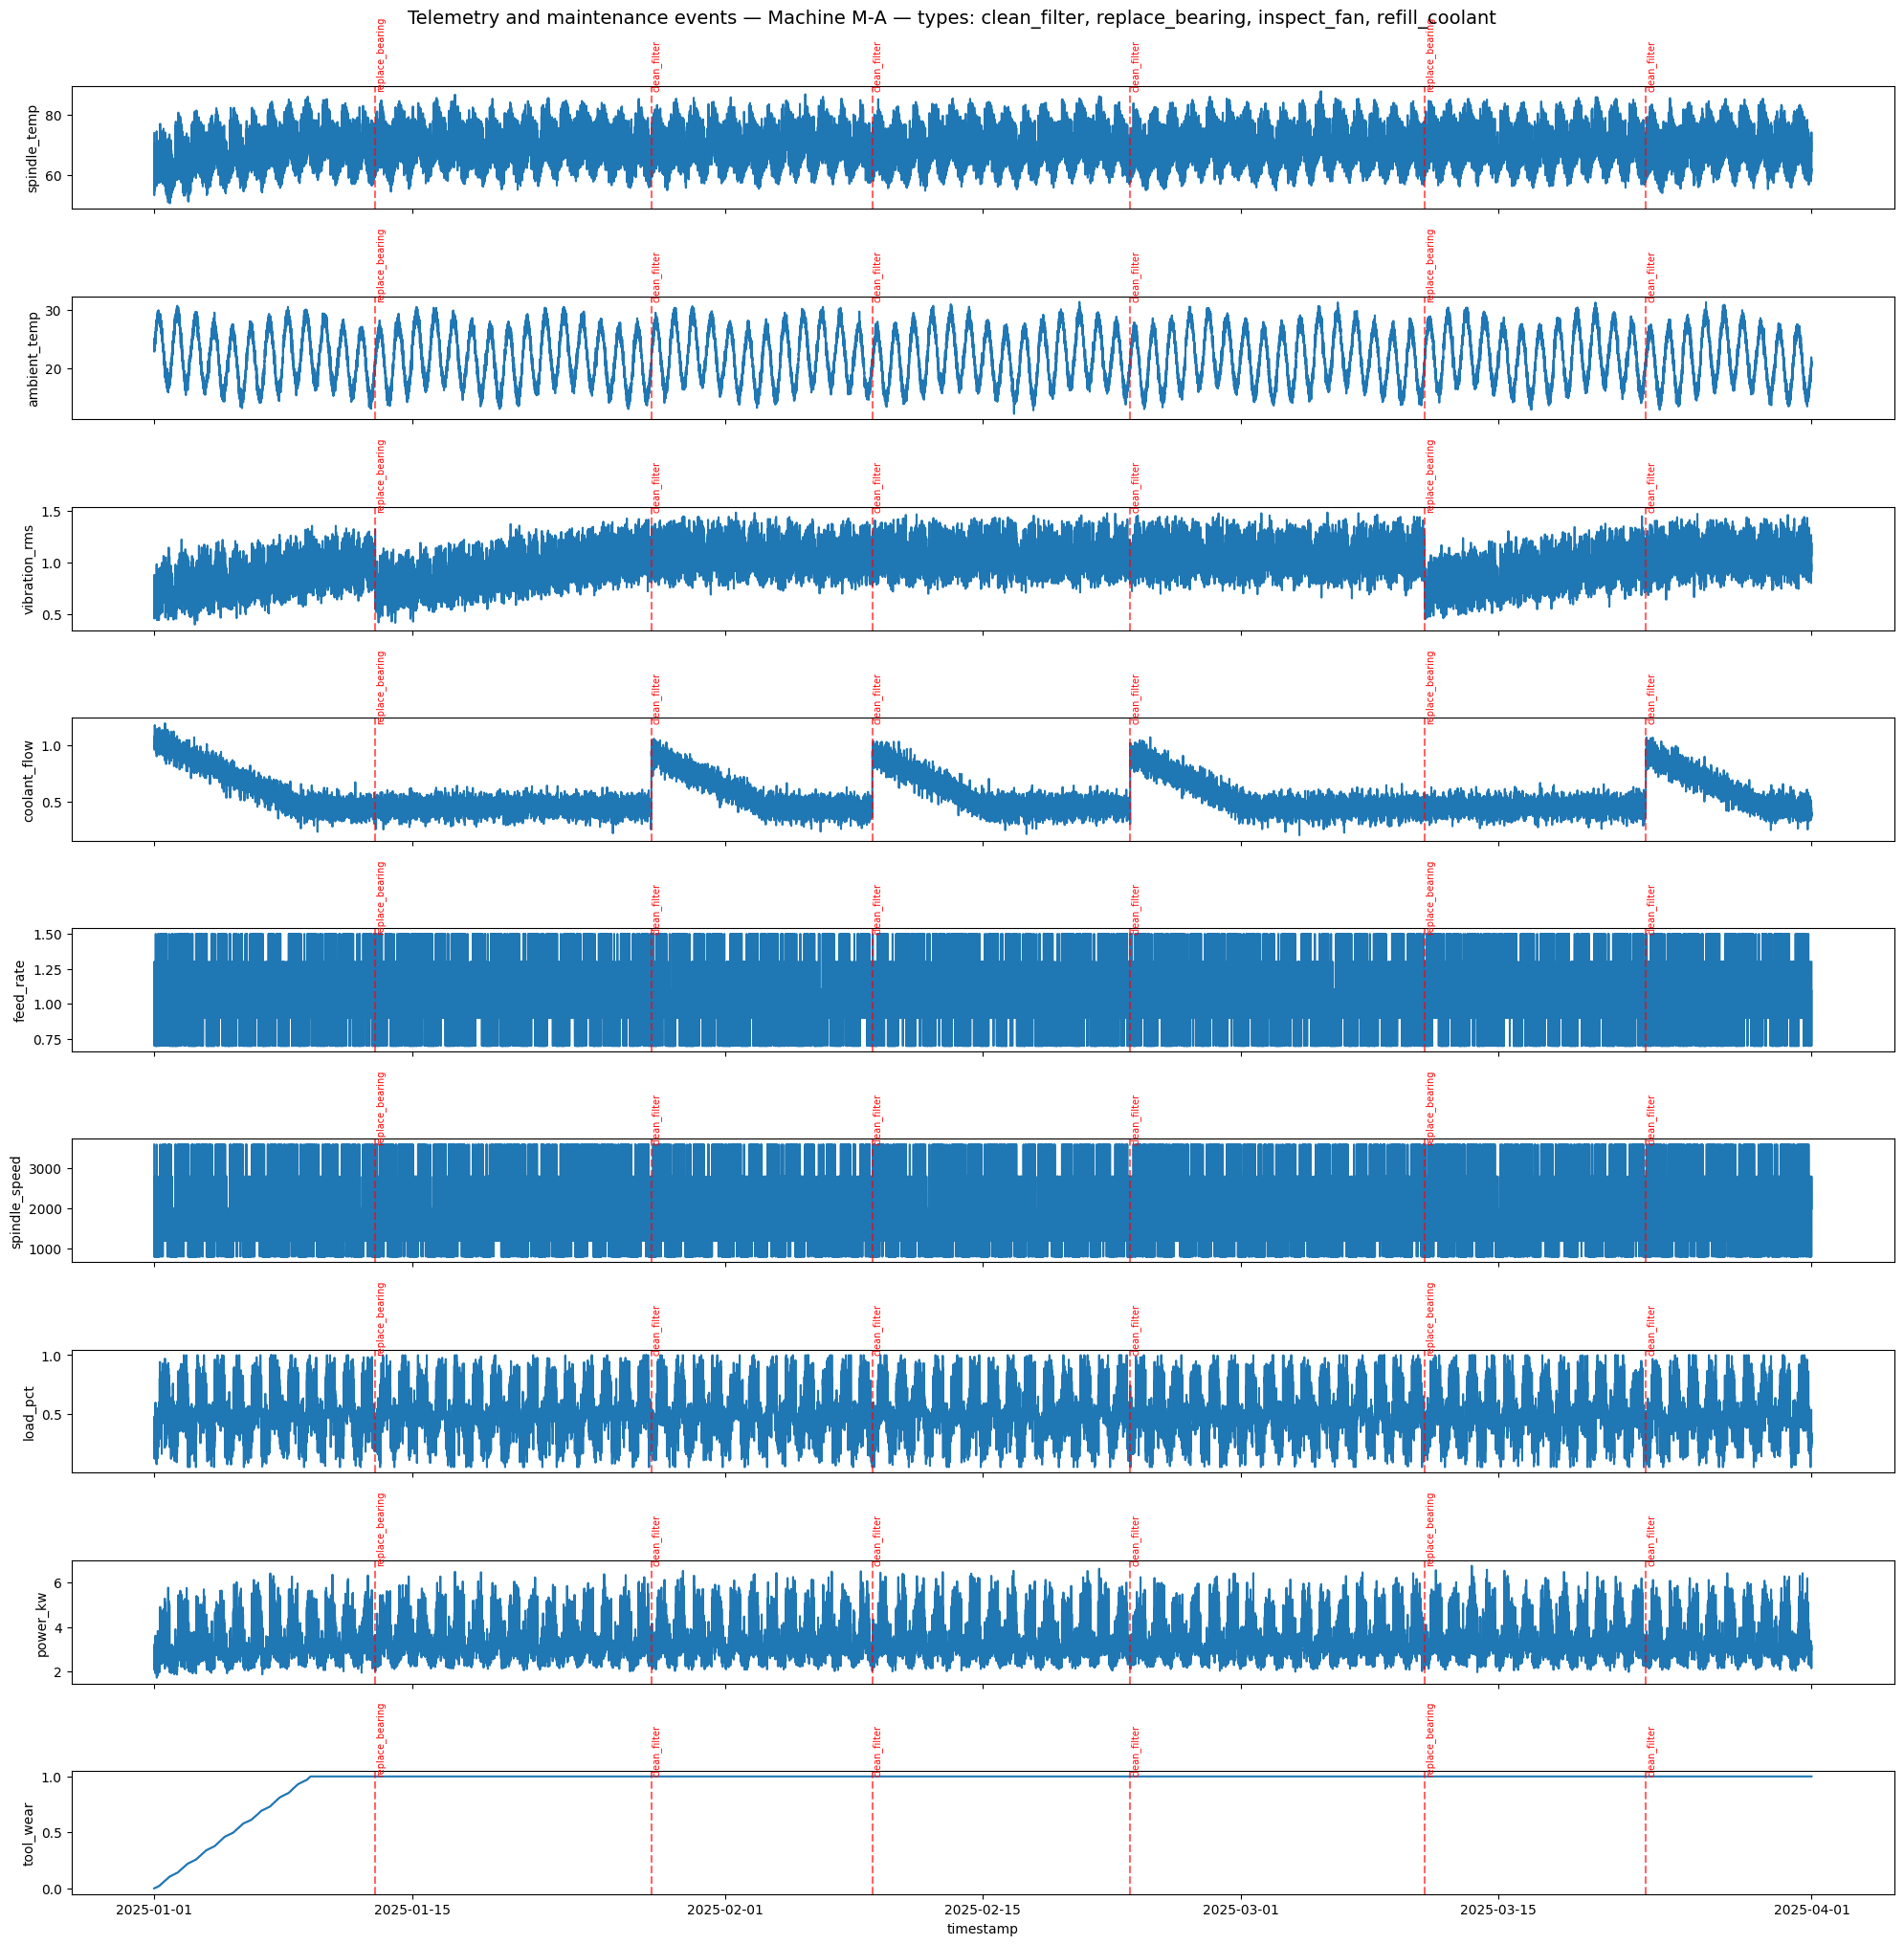

In [51]:
print("===== Machine A =====")
plot_all_features_with_maintenance(merged_data, maintenance, machine_id="M-A", sensor_cols=sensor_cols, maintenance_filter=["clean_filter", "replace_bearing", "inspect_fan", "refill_coolant"])

===== Machine B =====


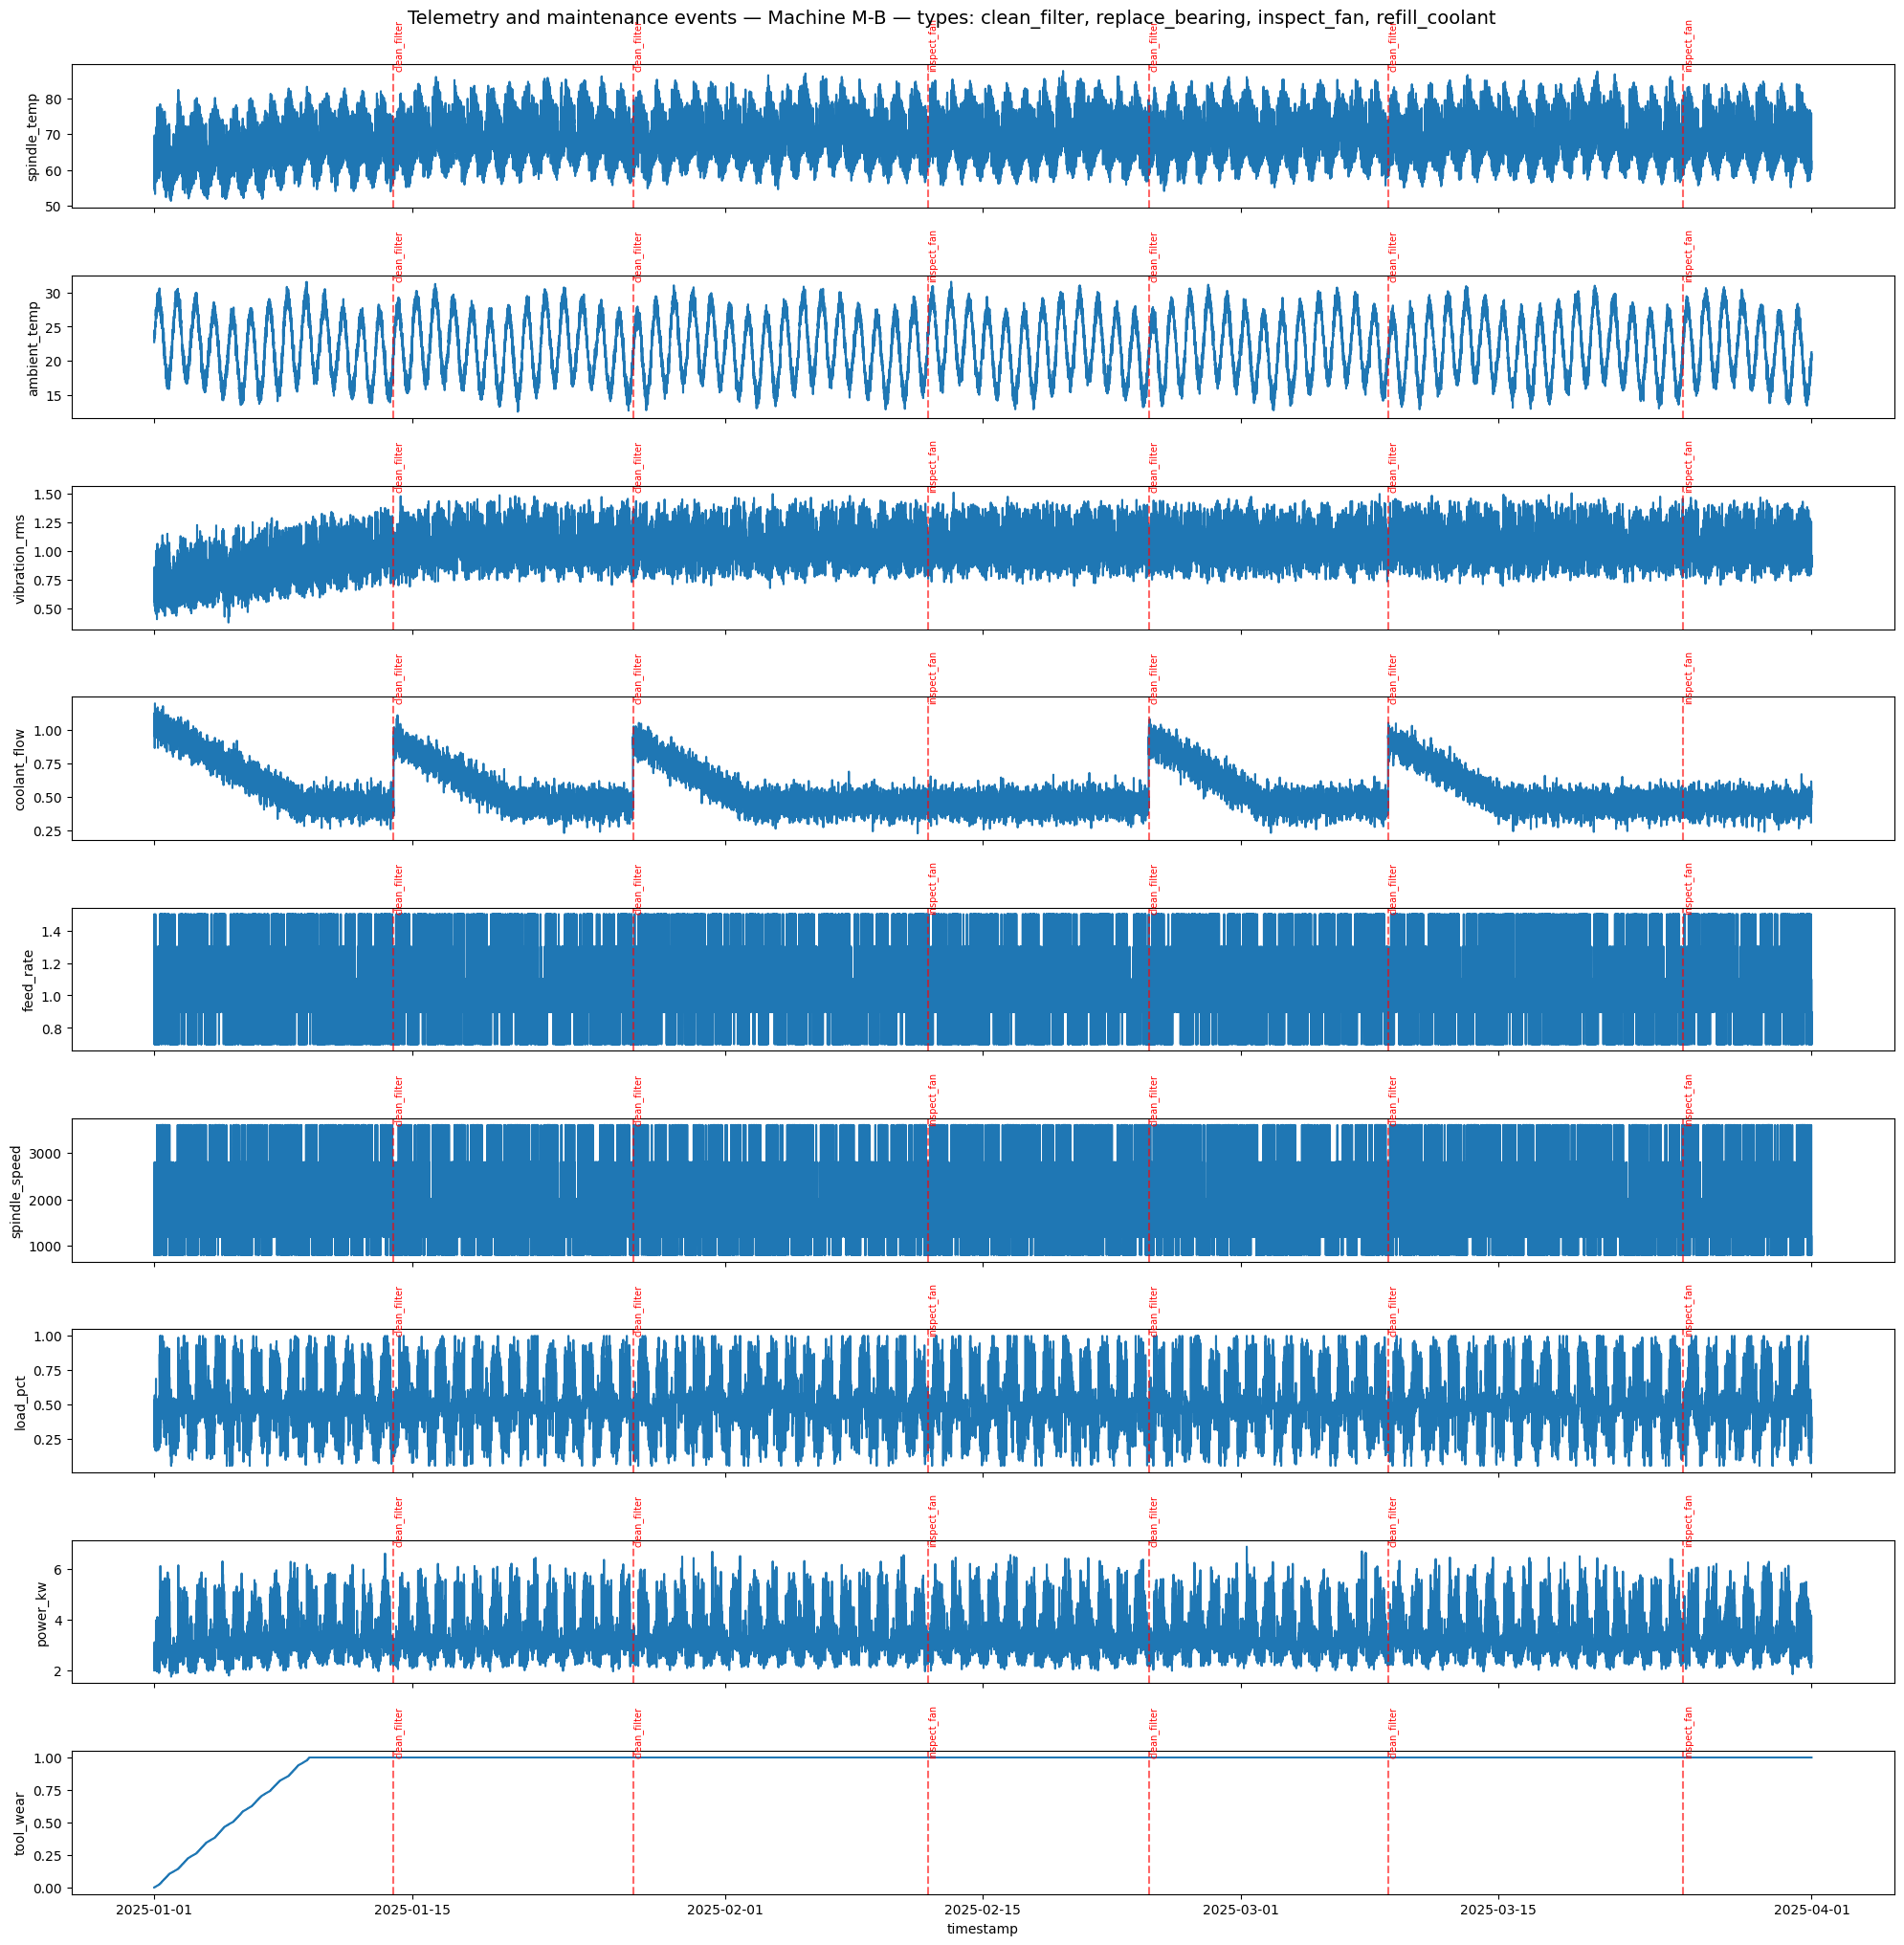

In [52]:
print("===== Machine B =====")
plot_all_features_with_maintenance(merged_data, maintenance, machine_id="M-B", sensor_cols=sensor_cols, maintenance_filter=["clean_filter", "replace_bearing", "inspect_fan", "refill_coolant"])

===== Machine C =====


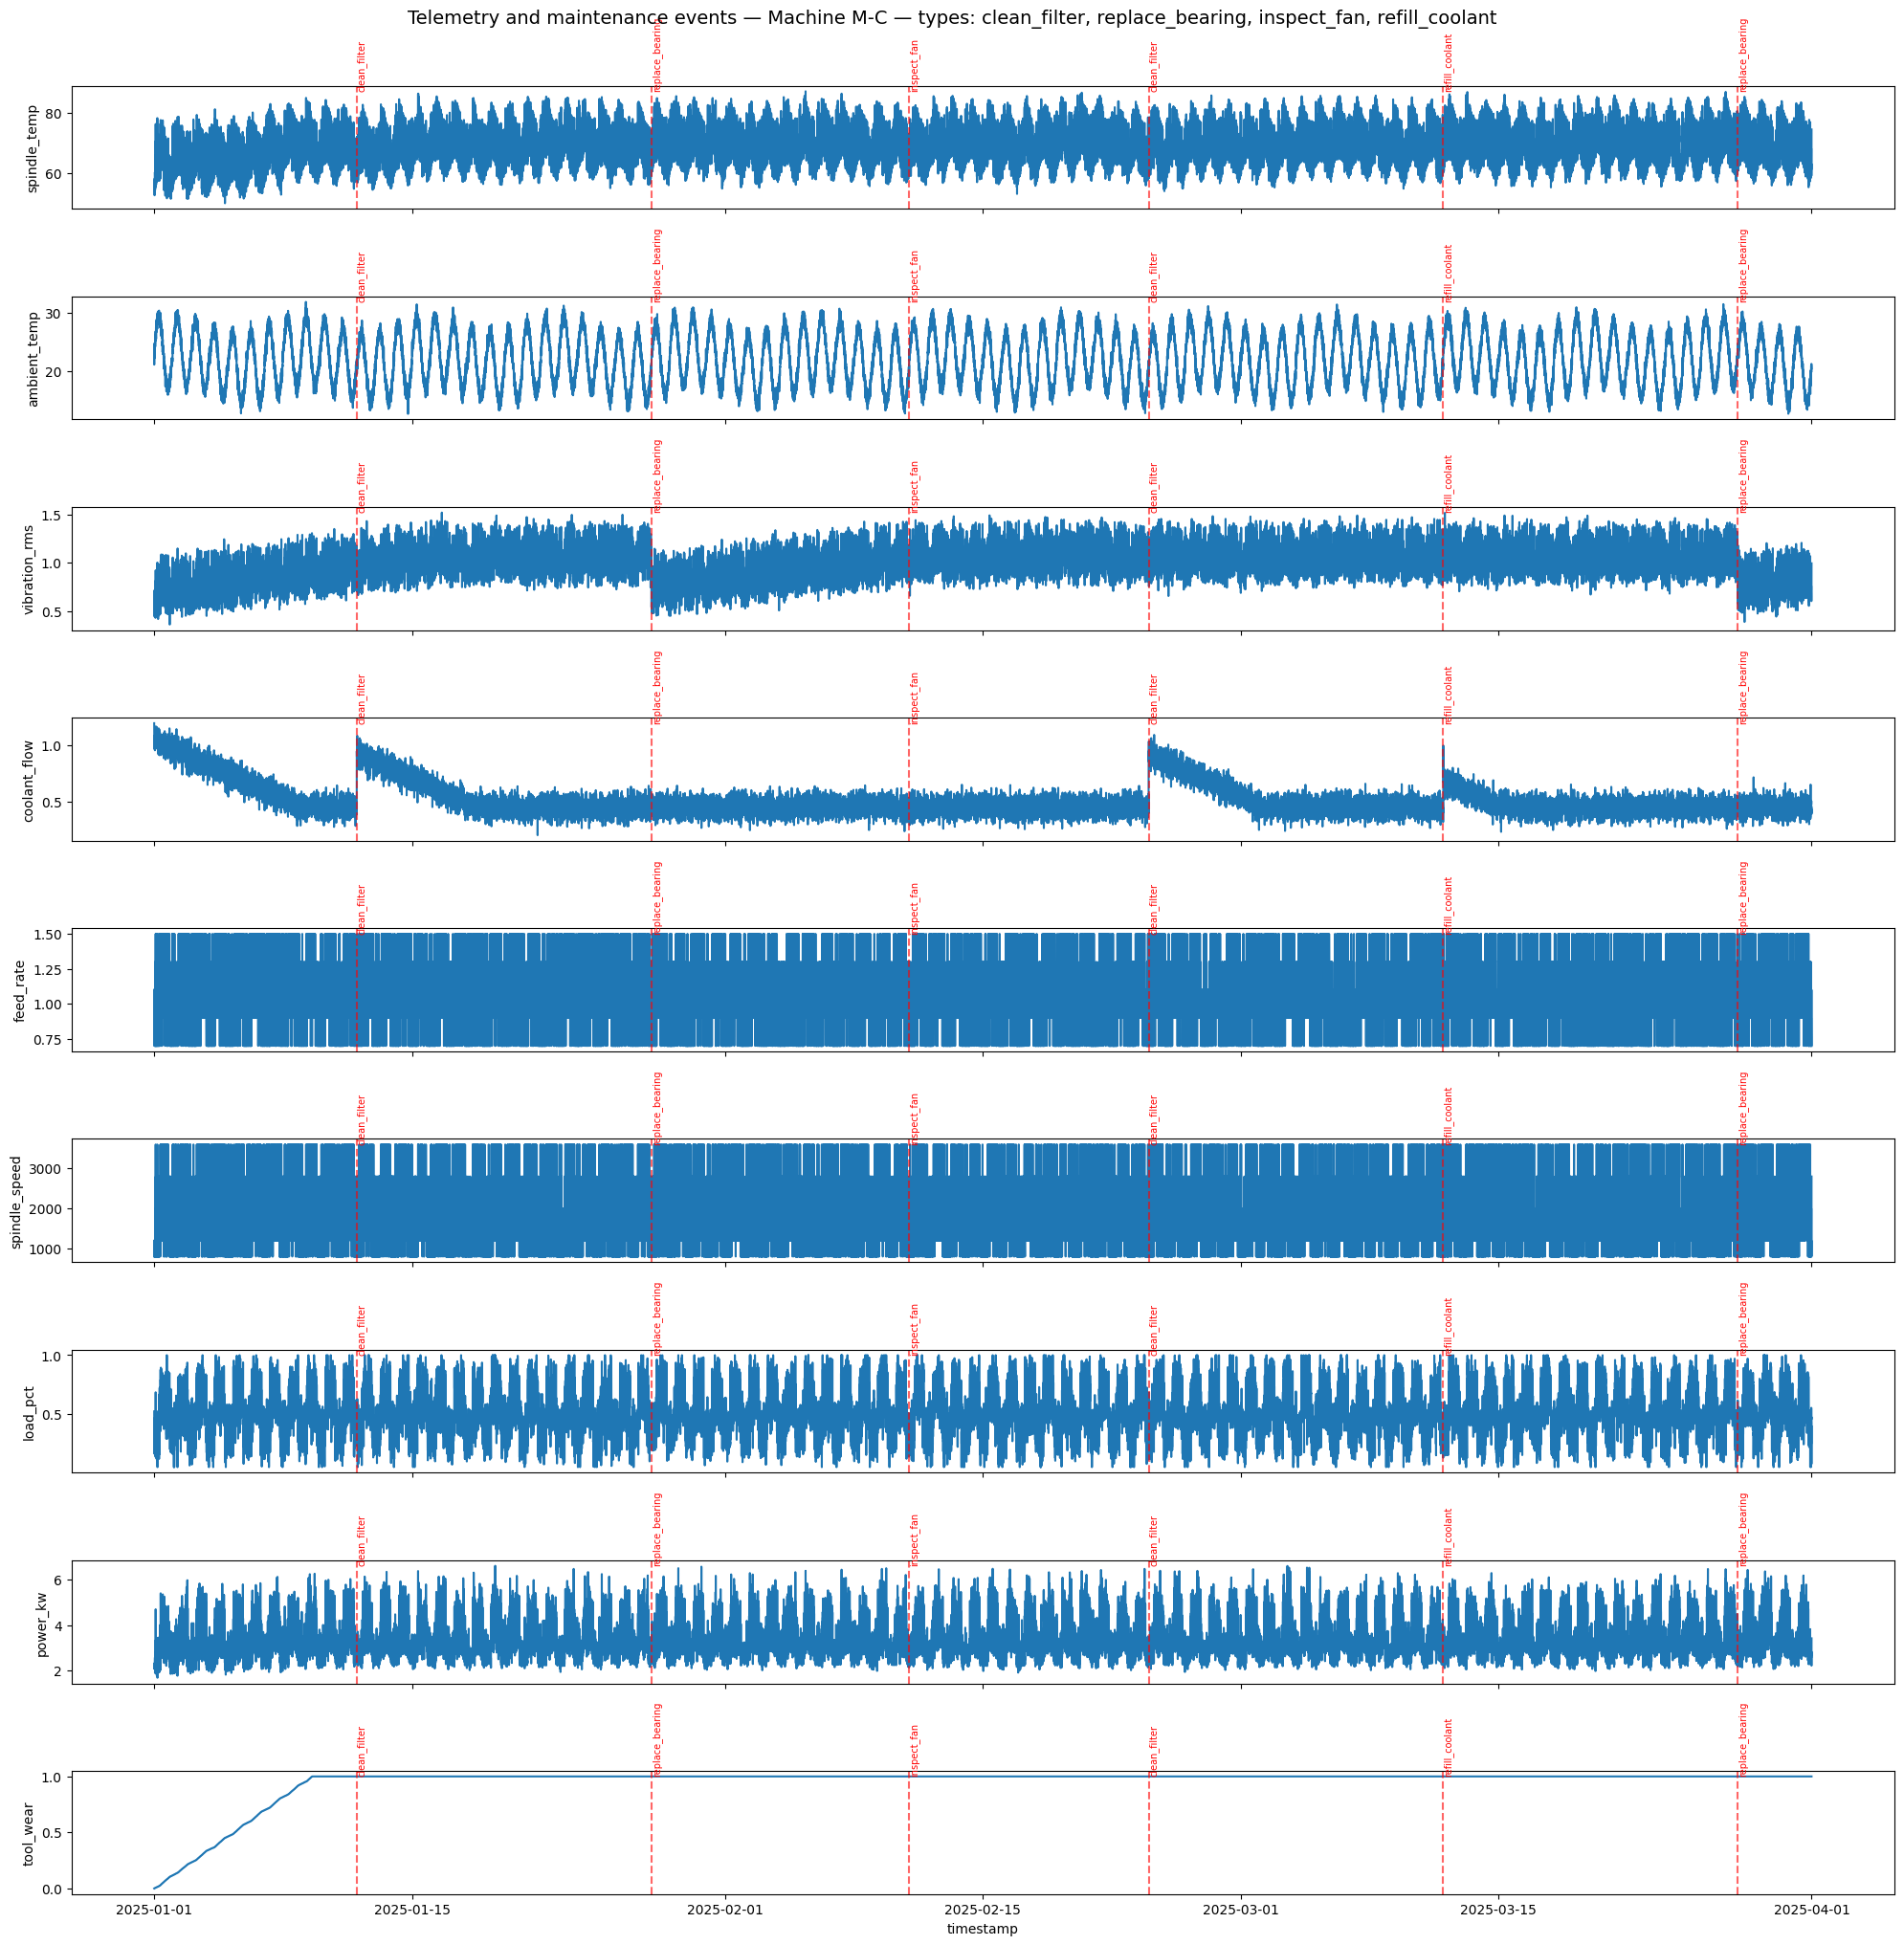

In [53]:
print("===== Machine C =====")
plot_all_features_with_maintenance(merged_data, maintenance, machine_id="M-C", sensor_cols=sensor_cols, maintenance_filter=["clean_filter", "replace_bearing", "inspect_fan", "refill_coolant"])

===== Machine D =====


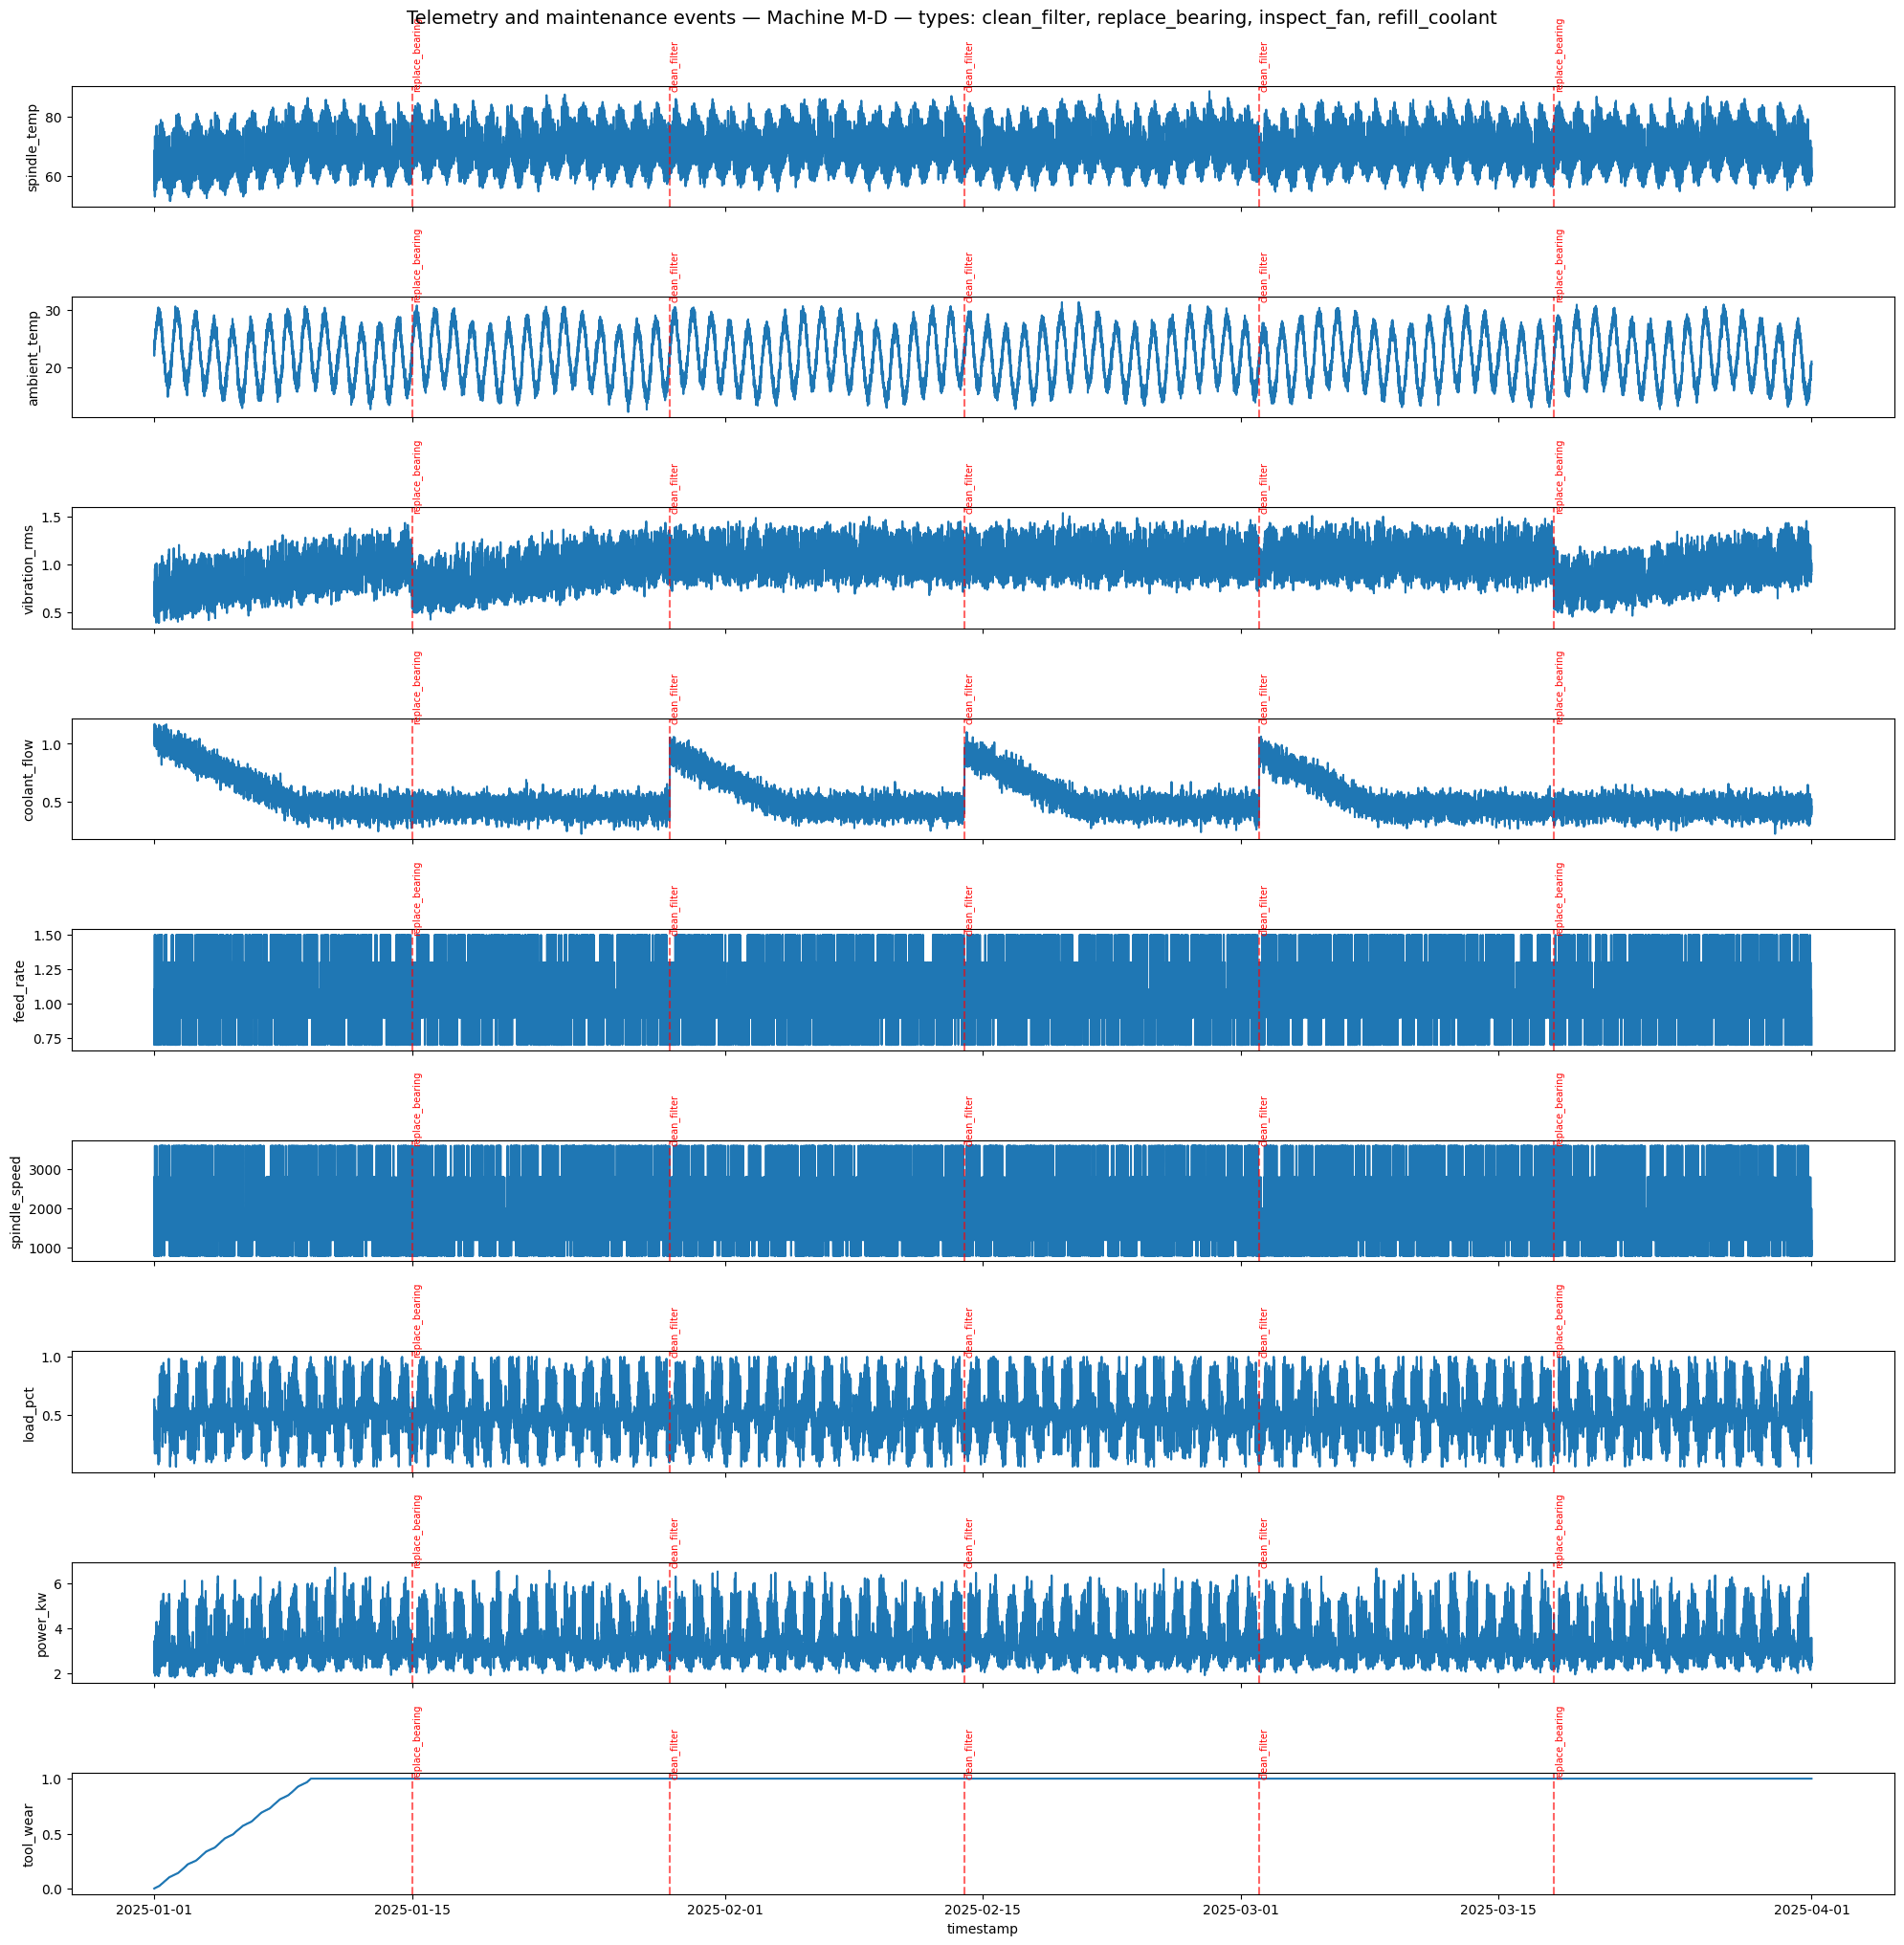

In [54]:
print("===== Machine D =====")
plot_all_features_with_maintenance(merged_data, maintenance, machine_id="M-D", sensor_cols=sensor_cols, maintenance_filter=["clean_filter", "replace_bearing", "inspect_fan", "refill_coolant"])

Through a very superficial analysis of all maintenance actions performed by the machine, it is possible to perceive that **some of these actions appear to strongly influence the values ​​of some variables** such as vibration_ms and coolant_flow. Furthermore, **the maintenance actions do not seem to be performed at constant time intervals, suggesting that they are performed when the system reaches certain values**. Let's now analyze how each specific action influences the machines, since in the overall analysis each main action appears to have similar effects on each machine.

**`Clean Filter`**

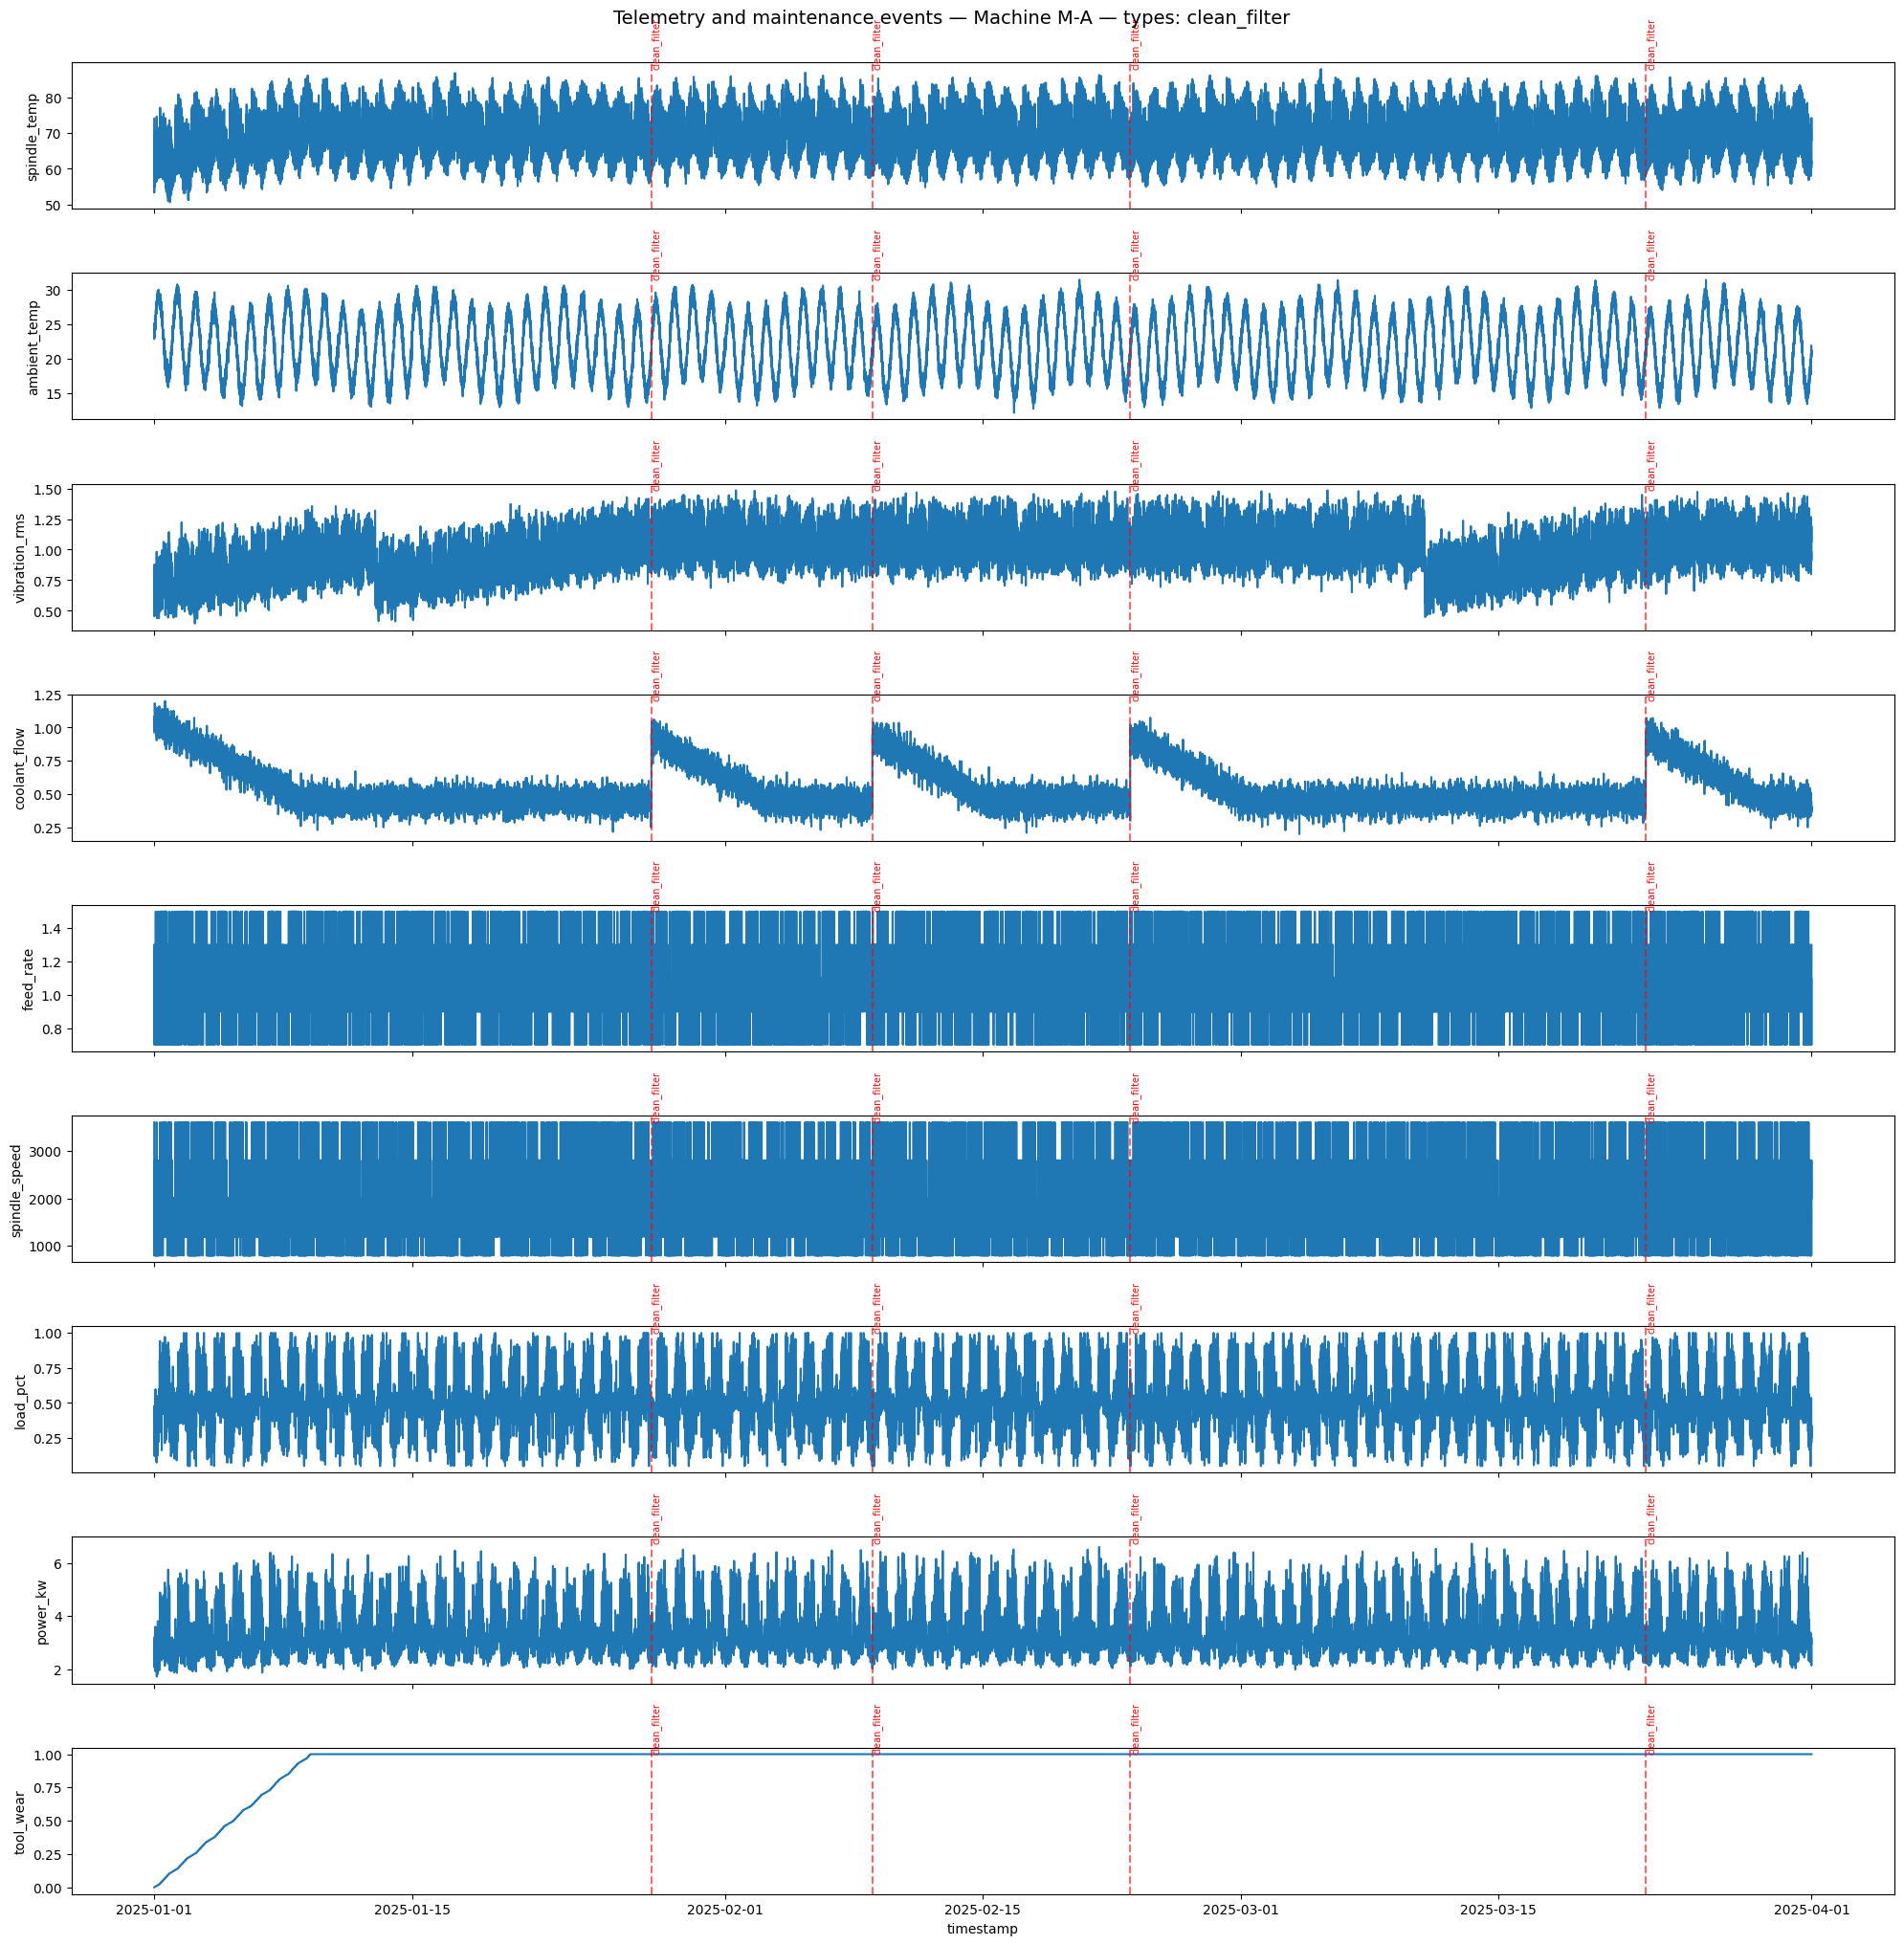

In [55]:
plot_all_features_with_maintenance(merged_data, maintenance, machine_id="M-A", sensor_cols=sensor_cols, maintenance_filter=["clean_filter"])


Impact of maintenance on machine M-A for feature 'coolant_flow':
- 2025-01-28 00:00:00 | clean_filter
    mean coolant_flow over 12h BEFORE : 0.453
    mean coolant_flow over 12h AFTER  : 0.917
    Δ absolute: +0.463   Δ relative: +102.3%
- 2025-02-09 00:00:00 | clean_filter
    mean coolant_flow over 12h BEFORE : 0.452
    mean coolant_flow over 12h AFTER  : 0.903
    Δ absolute: +0.451   Δ relative: +100.0%
- 2025-02-23 00:00:00 | clean_filter
    mean coolant_flow over 12h BEFORE : 0.444
    mean coolant_flow over 12h AFTER  : 0.906
    Δ absolute: +0.462   Δ relative: +103.9%
- 2025-03-23 00:00:00 | clean_filter
    mean coolant_flow over 12h BEFORE : 0.450
    mean coolant_flow over 12h AFTER  : 0.918
    Δ absolute: +0.468   Δ relative: +104.0%

Summary by maintenance type:
                  delta  delta_pct
maintenance_type                  
clean_filter      0.461    102.533


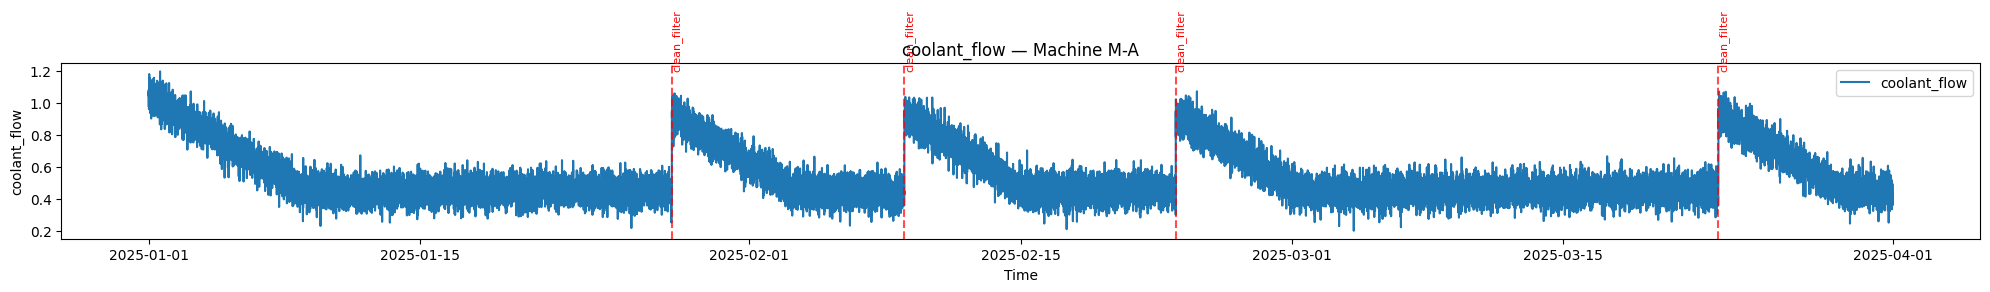

In [56]:
_ = plot_machine_feature_with_maintenance_and_impact(merged_data, maintenance, machine_id="M-A", feature="coolant_flow",
    maintenance_filter=["clean_filter"], before_hours=12, after_hours=12)

For the `clean_filter` maintenance action on machine M-A we computed the average coolant flow in the 12 hours immediately before and after each intervention. Across the four events, the mean coolant flow increased from approximately 0.45 (before) to 0.91 (after). This corresponds to an average absolute increase of 0.461 and a relative increase of about 102.5 %. The results are highly consistent across events, with very similar “before” and “after” values each time. It is also important to note that what happened on this machine is also confirmed on the others.

These figures indicate that, at the moment when clean_filter is performed, the coolant flow has dropped to roughly half of its post-maintenance value. In other words, filter cleaning almost doubles the available coolant flow in the short term. This provides strong empirical support for the causal link assumed in our Bayesian Network, namely that a clogged filter leads to low coolant flow, and that the clean_filter procedure effectively restores the cooling capacity of the system.

Analyzing the other characteristics for this type of maintenance, it was possible to verify that only `coolant_flow` was actually impacted.

**`Replace Bearing`**

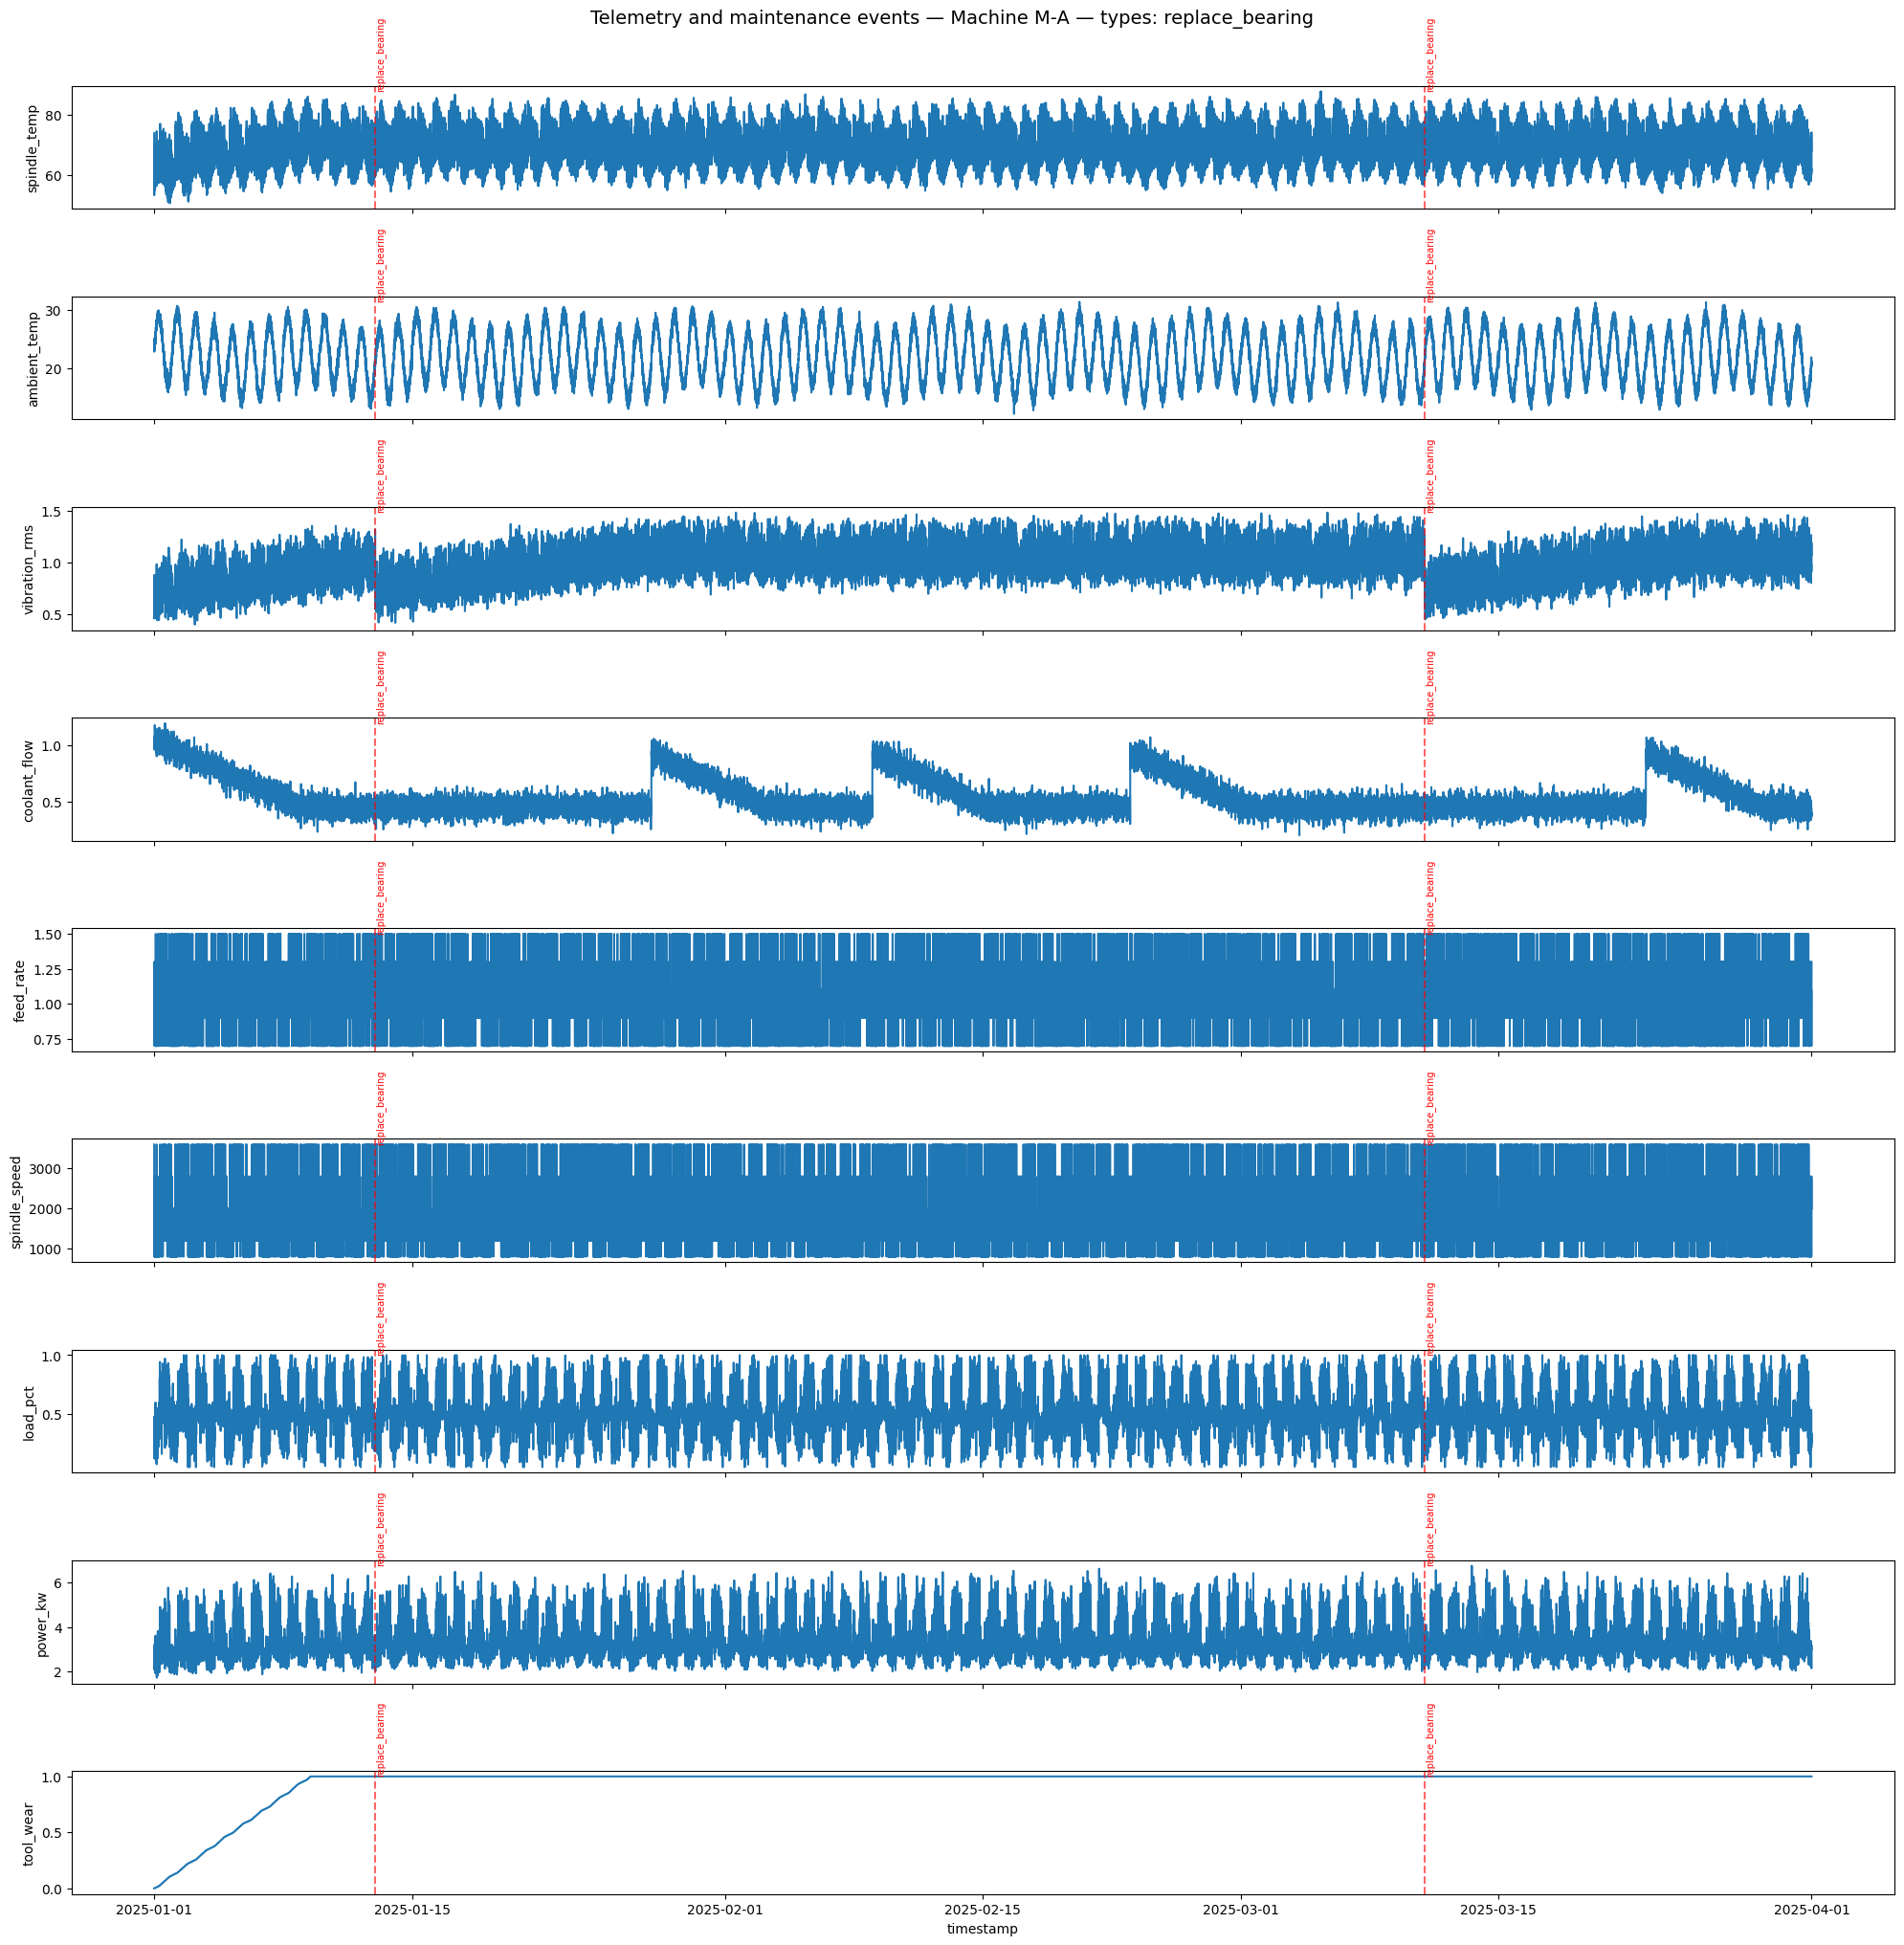

In [57]:
plot_all_features_with_maintenance(merged_data, maintenance, machine_id="M-A", sensor_cols=sensor_cols, maintenance_filter=["replace_bearing"])


Impact of maintenance on machine M-A for feature 'vibration_rms':
- 2025-01-13 00:00:00 | replace_bearing
    mean vibration_rms over 12h BEFORE : 0.983
    mean vibration_rms over 12h AFTER  : 0.701
    Δ absolute: -0.282   Δ relative: -28.7%
- 2025-03-11 00:00:00 | replace_bearing
    mean vibration_rms over 12h BEFORE : 1.065
    mean vibration_rms over 12h AFTER  : 0.691
    Δ absolute: -0.374   Δ relative: -35.1%

Summary by maintenance type:
                  delta  delta_pct
maintenance_type                  
replace_bearing  -0.328    -31.891


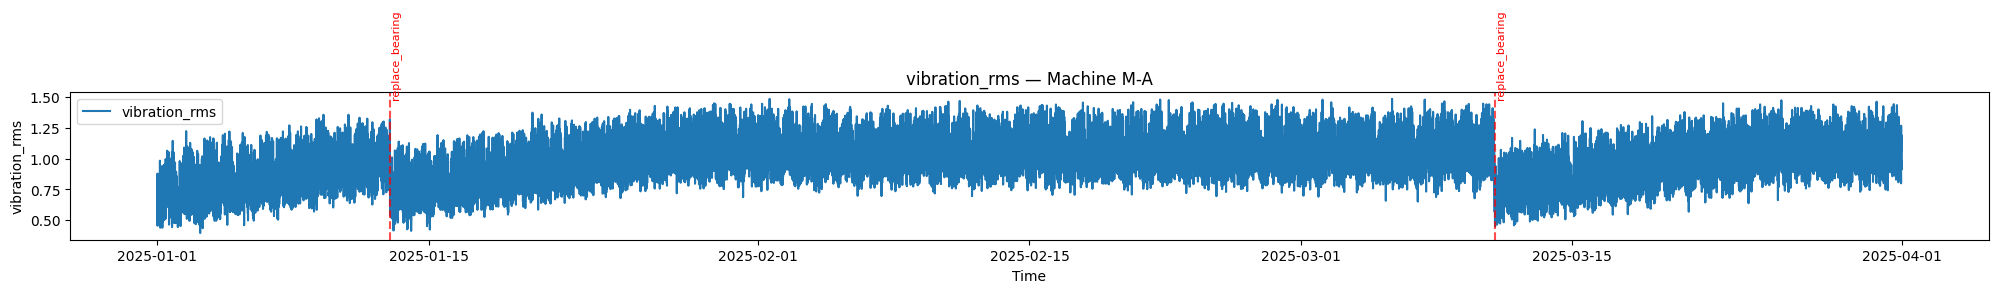

In [58]:
_ = plot_machine_feature_with_maintenance_and_impact(merged_data, maintenance, machine_id="M-A", feature="vibration_rms",
    maintenance_filter=["replace_bearing"], before_hours=12, after_hours=12)

For the `replace_bearing` maintenance action on machine M-A we measured the average vibration level (vibration_rms) in the 12 hours before and after each intervention. In the first event, the mean vibration decreased from 0.983 to 0.701 and in the second, from 1.065 to 0.691. Overall, **bearing replacement reduced the average vibration** by approximately 0.328 units, corresponding to a relative decrease of about 31.9%.

This indicates that, at the time when replace_bearing is performed, the machine is operating with vibration levels roughly one third higher than the post-maintenance baseline. In other words, **bearing replacement consistently brings vibration back to a substantially lower, healthier regime**. This behaviour is fully consistent with the intended causal relationship in our Bayesian Network, where increased bearing wear leads to high vibration, and the replace_bearing procedure mitigates this cause and restores normal vibration levels.

**`Refill Coolant == Flush Coolant???`**

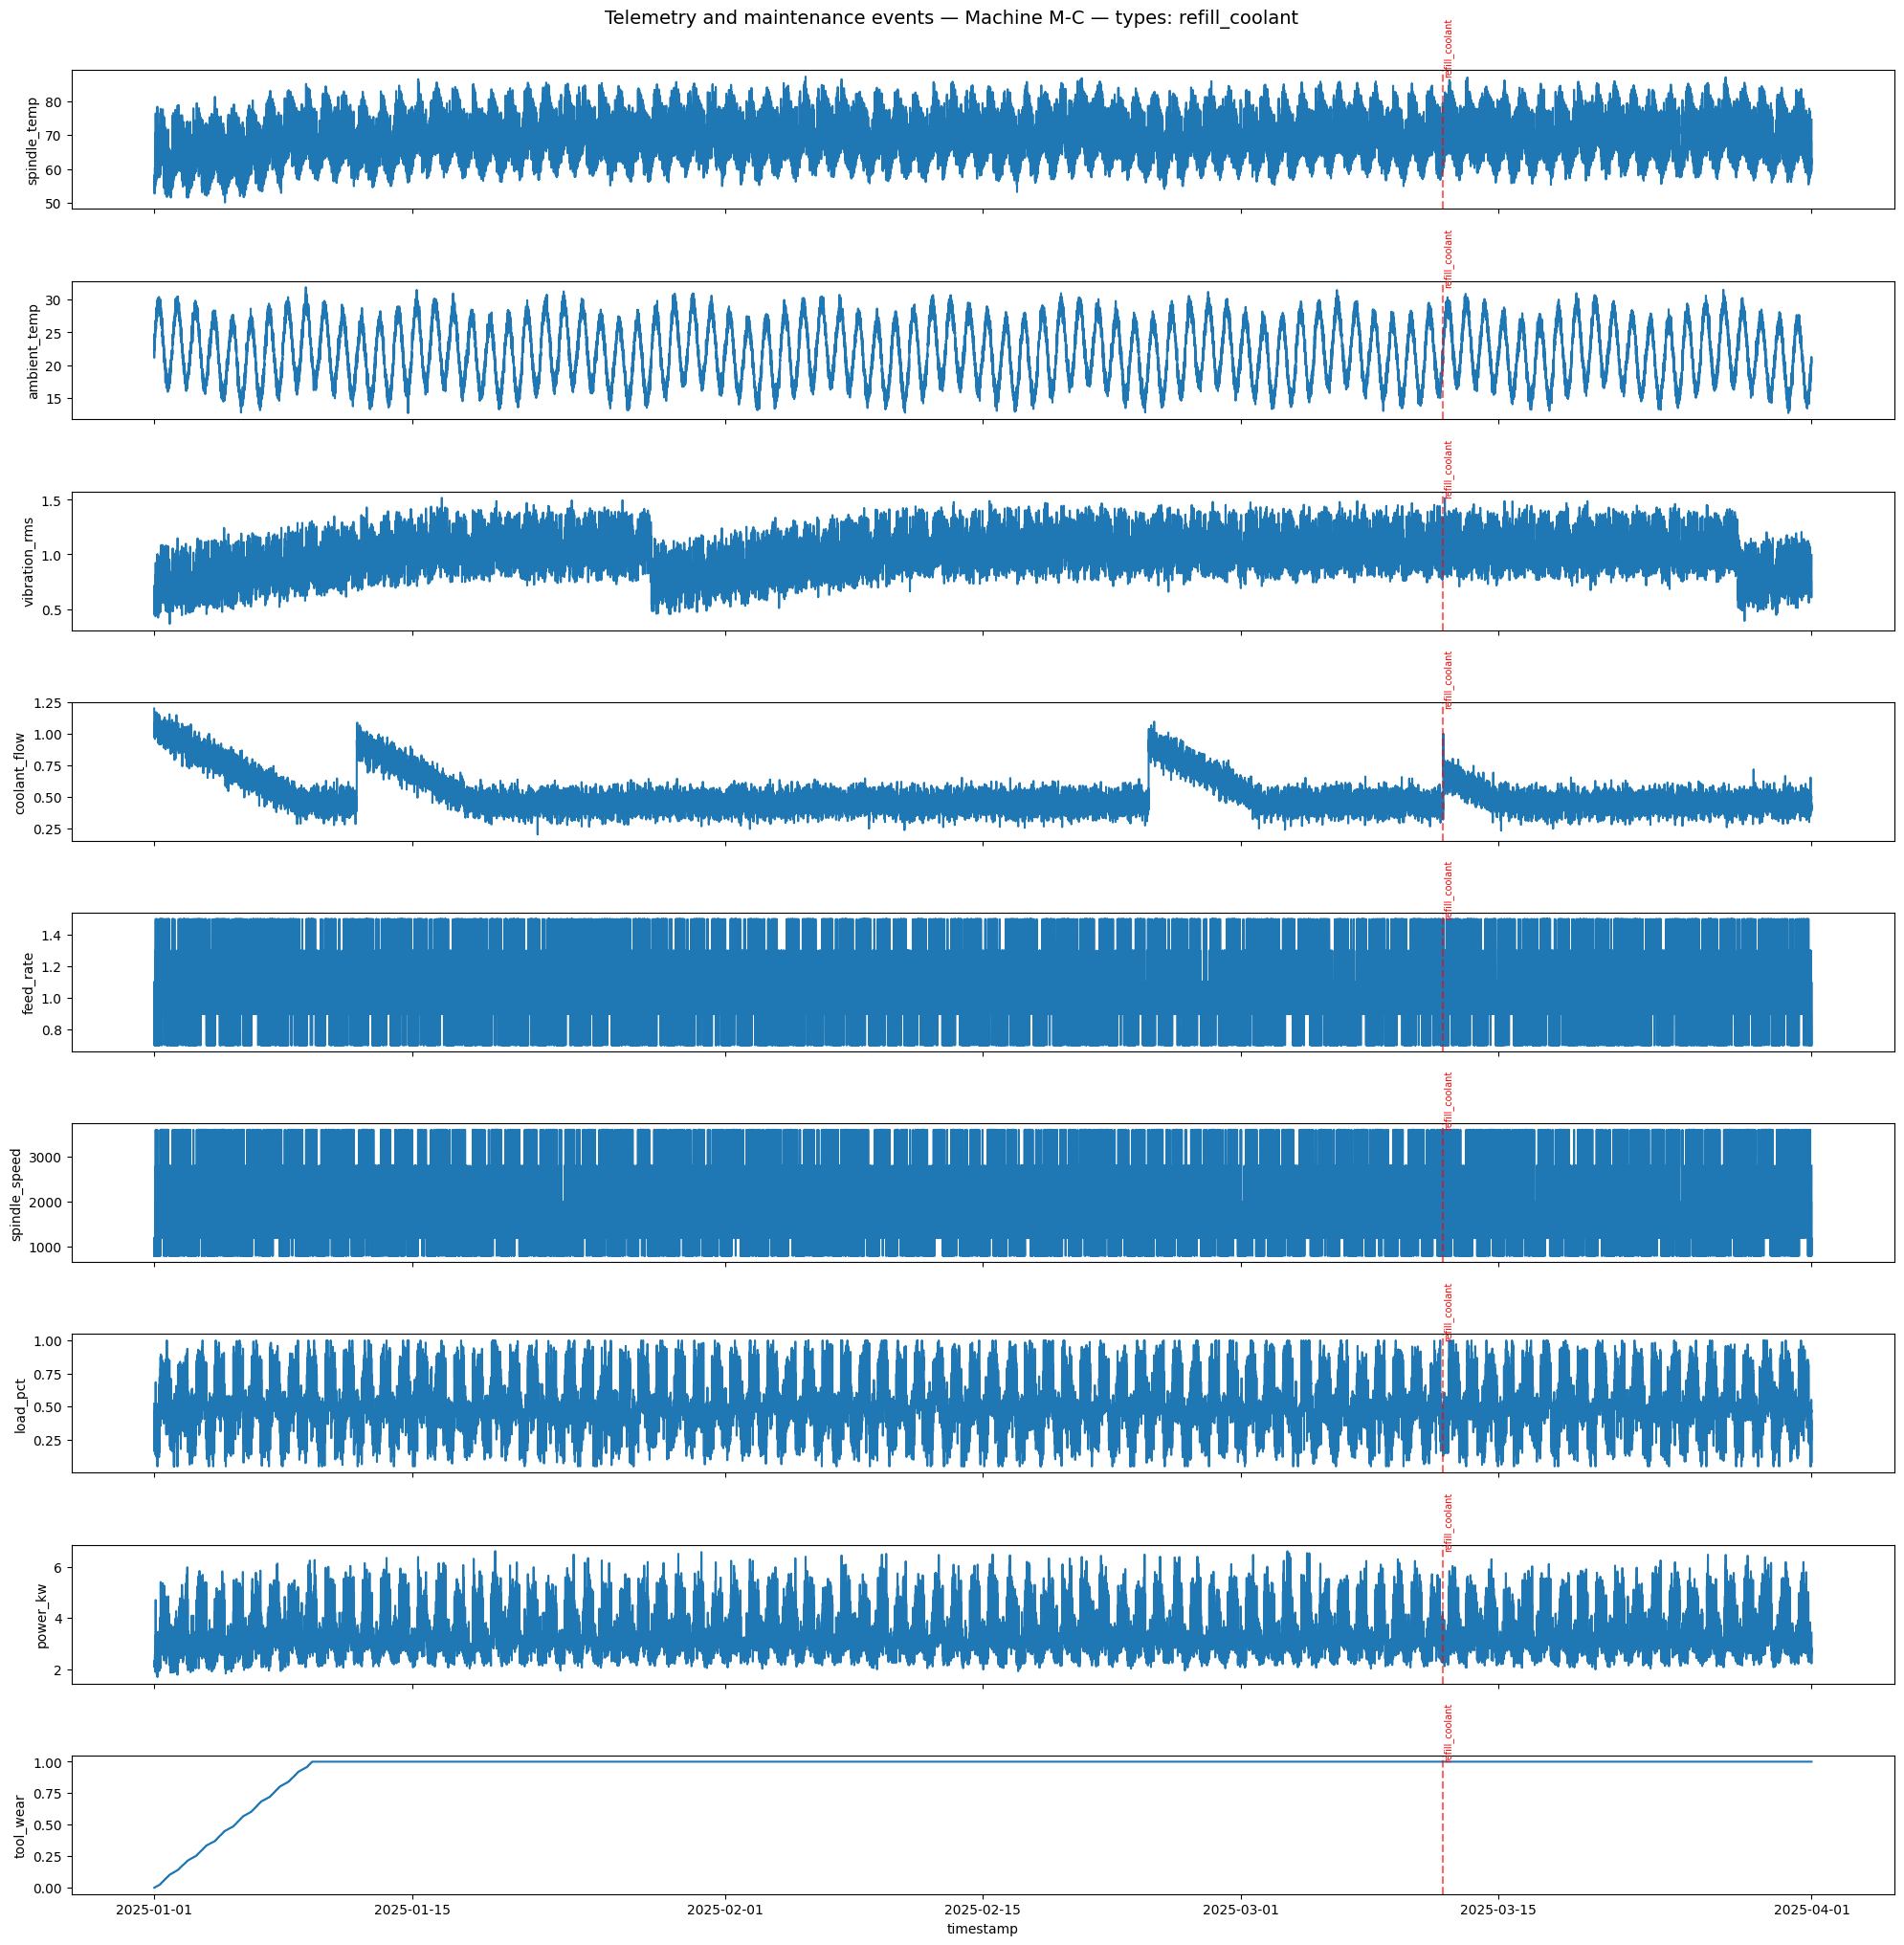

In [59]:
plot_all_features_with_maintenance(merged_data, maintenance, machine_id="M-C", sensor_cols=sensor_cols, maintenance_filter=["refill_coolant"])


Impact of maintenance on machine M-C for feature 'coolant_flow':
- 2025-03-12 00:00:00 | refill_coolant
    mean coolant_flow over 12h BEFORE : 0.446
    mean coolant_flow over 12h AFTER  : 0.666
    Δ absolute: +0.220   Δ relative: +49.4%

Summary by maintenance type:
                  delta  delta_pct
maintenance_type                  
refill_coolant     0.22     49.378


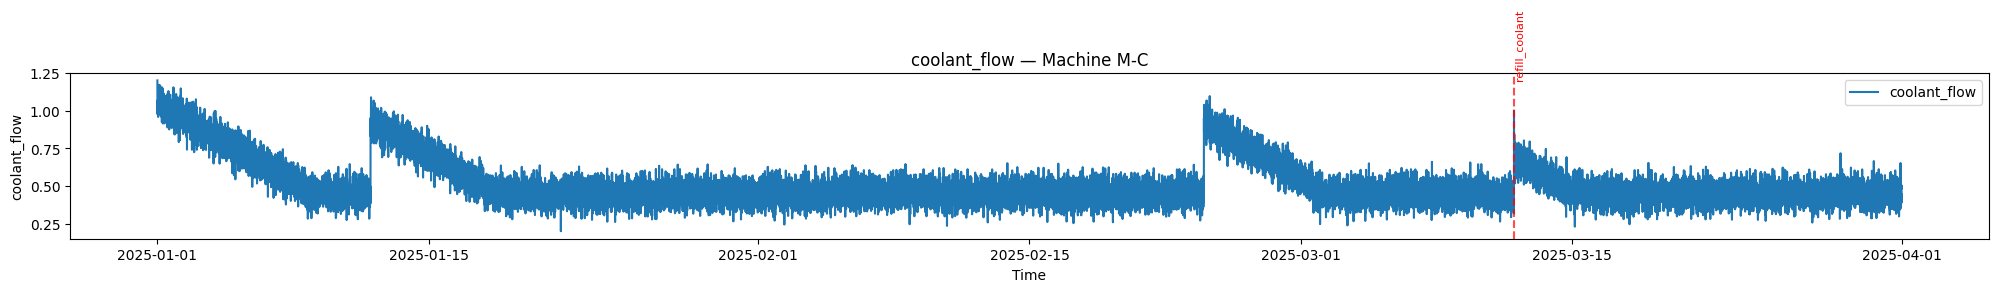

In [60]:
_ = plot_machine_feature_with_maintenance_and_impact(merged_data, maintenance, machine_id="M-C", feature="coolant_flow",
    maintenance_filter=["refill_coolant"], before_hours=12, after_hours=12)


Impact of maintenance on machine M-C for feature 'spindle_temp':
- 2025-03-12 00:00:00 | refill_coolant
    mean spindle_temp over 12h BEFORE : 66.523
    mean spindle_temp over 12h AFTER  : 71.064
    Δ absolute: +4.541   Δ relative: +6.8%

Summary by maintenance type:
                  delta  delta_pct
maintenance_type                  
refill_coolant    4.541      6.826


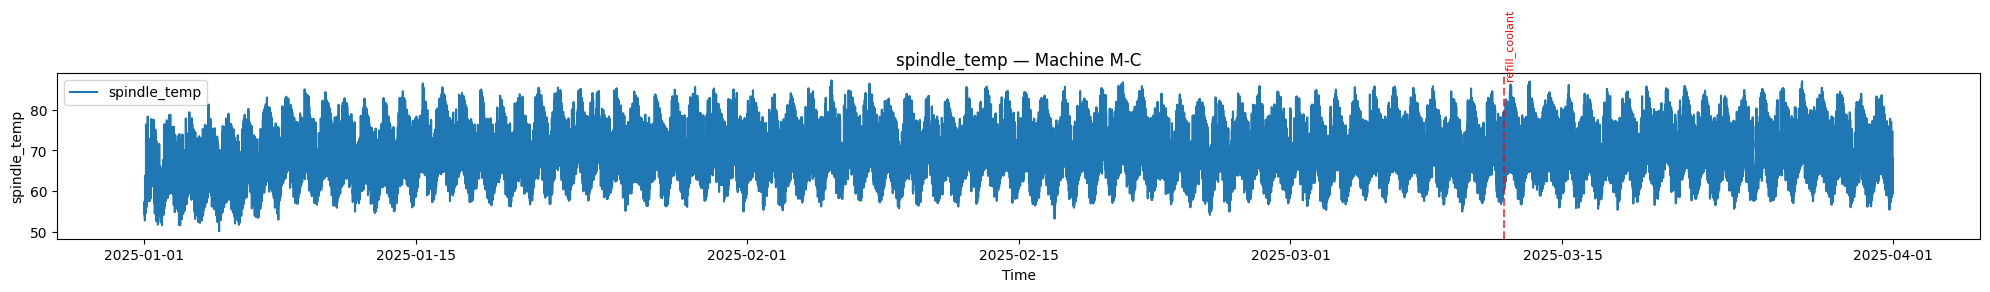

In [61]:
_ = plot_machine_feature_with_maintenance_and_impact(merged_data, maintenance, machine_id="M-C", feature="spindle_temp",
    maintenance_filter=["refill_coolant"], before_hours=12, after_hours=12)

The knowledge base states that FlushCoolant mitigates LowCoolingEfficiency, which is directly linked to HighSpindleTemp. In our data, the only refill_coolant event analysed shows a clear increase in coolant_flow (+49.4%) but only a small change in spindle_temp (+6.8%) in the 12-hour window after the intervention. This suggests that the procedure has an immediate and measurable effect on coolant flow, while the impact on spindle temperature is more subtle and likely confounded by varying operating conditions. 

In the available data, we do not observe a strong, direct reduction in average spindle temperature after refill_coolant, likely because temperature is heavily influenced by varying operating conditions. We therefore rely on coolant flow as the main observable improvement, and retain the cooling–temperature link at the causal level rather than as a strongly data-driven effect.

**Note: We're not sure if Flush Coolant and Refill Coolant are the same action, which could explain these unexpected results.**

**`Inspect Fan == Repair Fan???`**

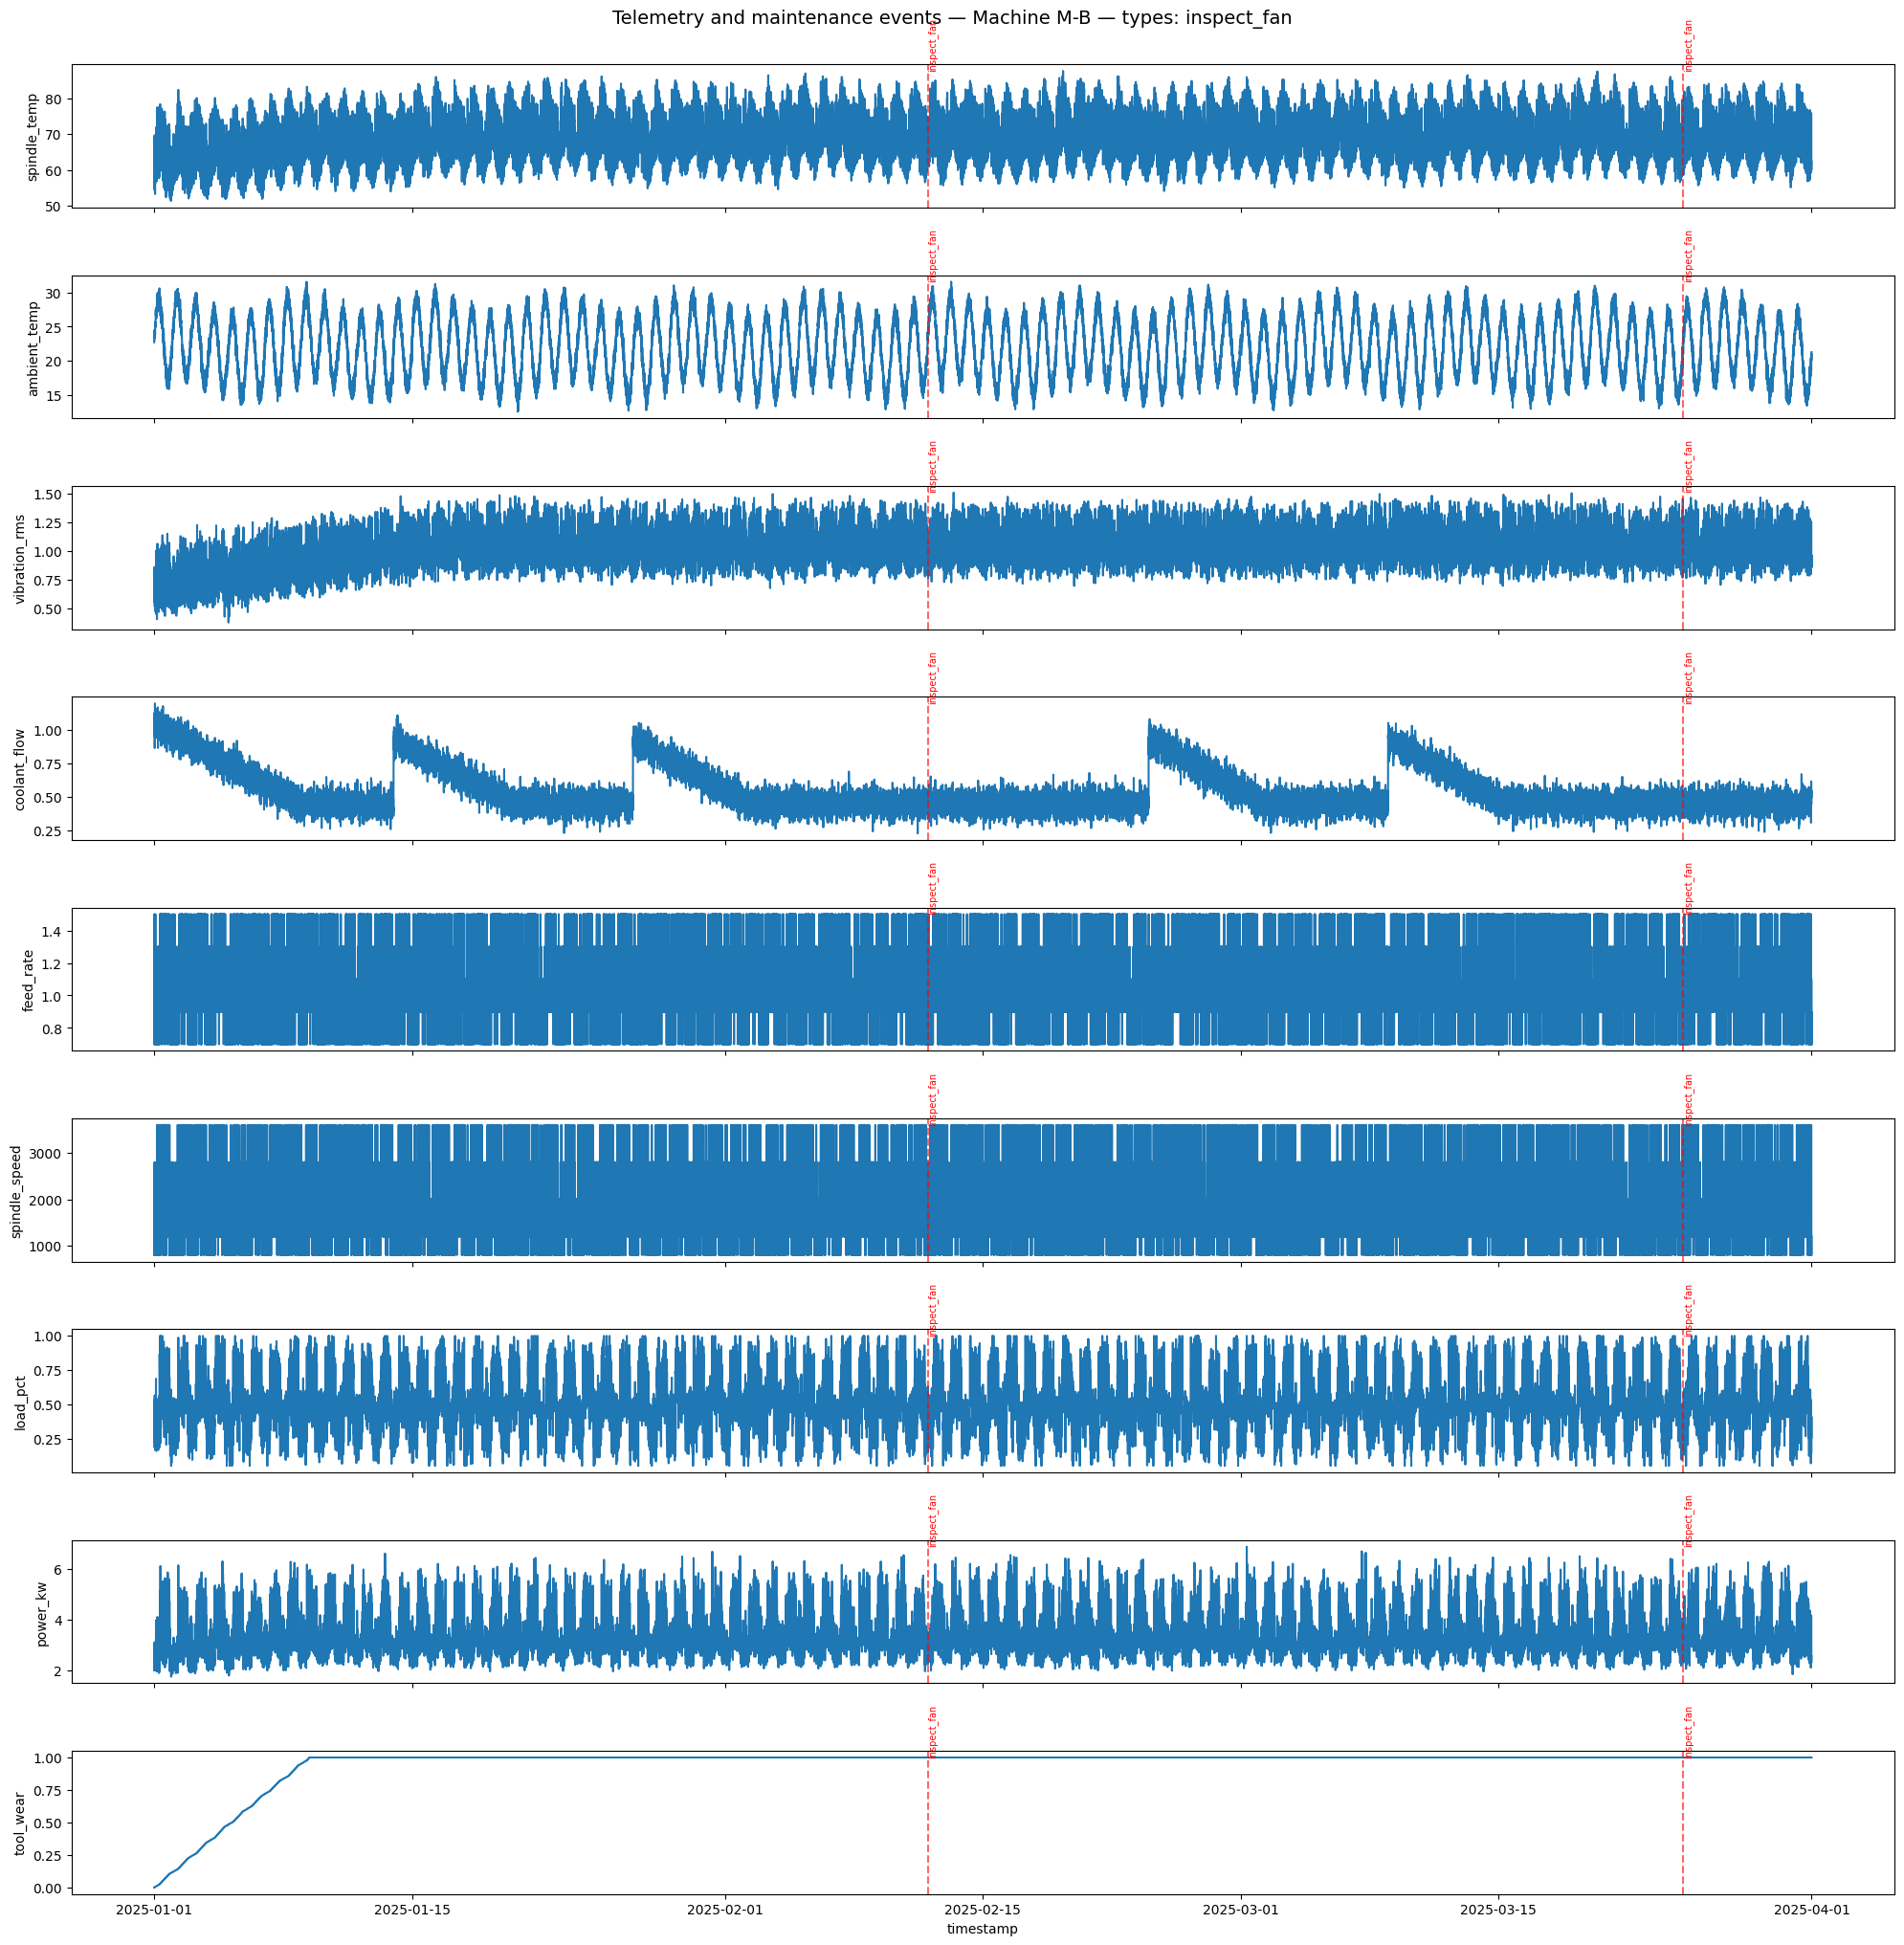

In [62]:
plot_all_features_with_maintenance(merged_data, maintenance, machine_id="M-B", sensor_cols=sensor_cols, maintenance_filter=["inspect_fan"])


Impact of maintenance on machine M-B for feature 'coolant_flow':
- 2025-02-12 00:00:00 | inspect_fan
    mean coolant_flow over 12h BEFORE : 0.450
    mean coolant_flow over 12h AFTER  : 0.454
    Δ absolute: +0.004   Δ relative: +0.8%
- 2025-03-25 00:00:00 | inspect_fan
    mean coolant_flow over 12h BEFORE : 0.447
    mean coolant_flow over 12h AFTER  : 0.450
    Δ absolute: +0.003   Δ relative: +0.6%

Summary by maintenance type:
                  delta  delta_pct
maintenance_type                  
inspect_fan       0.003      0.709


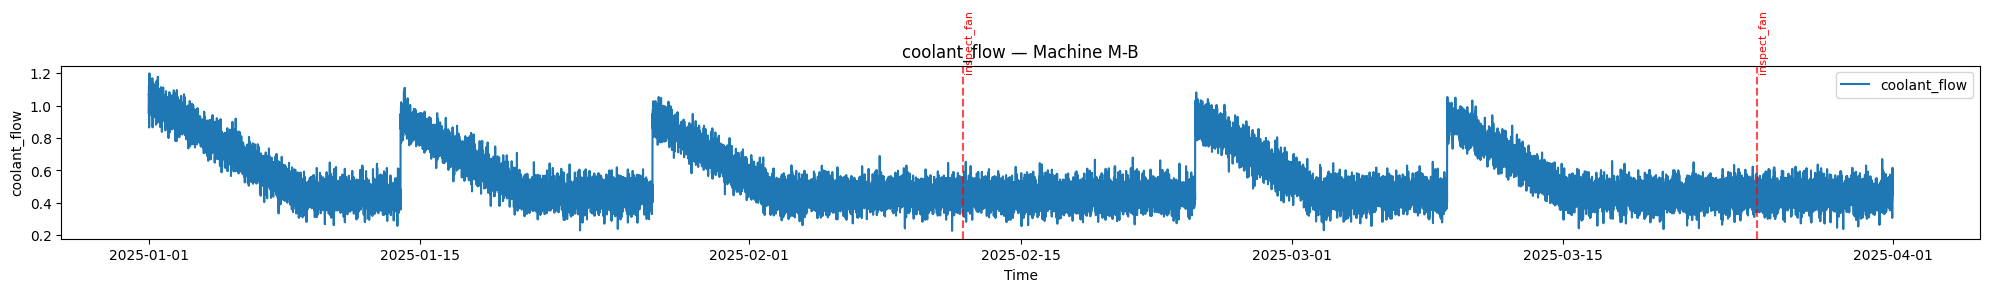

In [63]:
_ = plot_machine_feature_with_maintenance_and_impact(merged_data, maintenance, machine_id="M-B", feature="coolant_flow",
    maintenance_filter=["inspect_fan"], before_hours=12, after_hours=12)


Impact of maintenance on machine M-B for feature 'spindle_temp':
- 2025-02-12 00:00:00 | inspect_fan
    mean spindle_temp over 12h BEFORE : 66.813
    mean spindle_temp over 12h AFTER  : 69.710
    Δ absolute: +2.897   Δ relative: +4.3%
- 2025-03-25 00:00:00 | inspect_fan
    mean spindle_temp over 12h BEFORE : 65.993
    mean spindle_temp over 12h AFTER  : 69.237
    Δ absolute: +3.244   Δ relative: +4.9%

Summary by maintenance type:
                  delta  delta_pct
maintenance_type                  
inspect_fan        3.07      4.626


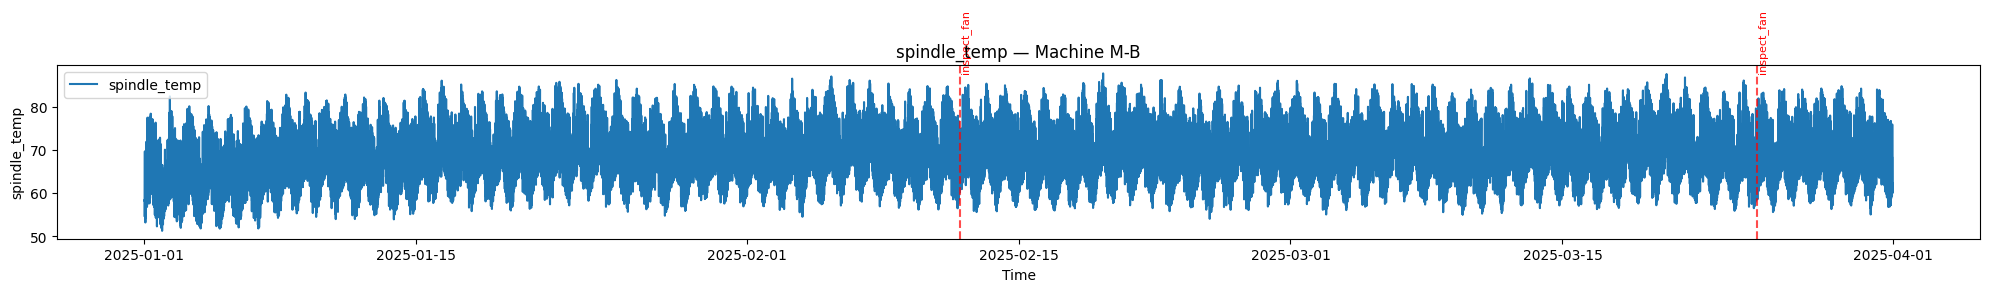

In [64]:
_ = plot_machine_feature_with_maintenance_and_impact(merged_data, maintenance, machine_id="M-B", feature="spindle_temp",
    maintenance_filter=["inspect_fan"], before_hours=12, after_hours=12)


Impact of maintenance on machine M-B for feature 'vibration_rms':
- 2025-02-12 00:00:00 | inspect_fan
    mean vibration_rms over 12h BEFORE : 1.049
    mean vibration_rms over 12h AFTER  : 1.026
    Δ absolute: -0.023   Δ relative: -2.2%
- 2025-03-25 00:00:00 | inspect_fan
    mean vibration_rms over 12h BEFORE : 1.061
    mean vibration_rms over 12h AFTER  : 1.035
    Δ absolute: -0.026   Δ relative: -2.5%

Summary by maintenance type:
                  delta  delta_pct
maintenance_type                  
inspect_fan      -0.025     -2.324


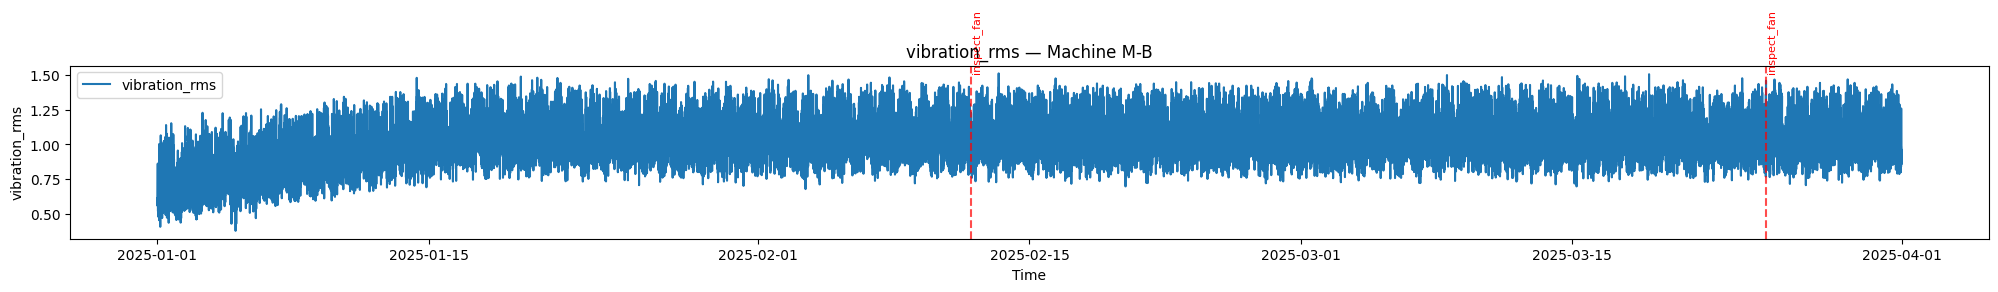

In [65]:
_ = plot_machine_feature_with_maintenance_and_impact(merged_data, maintenance, machine_id="M-B", feature="vibration_rms",
    maintenance_filter=["inspect_fan"], before_hours=12, after_hours=12)

When analyzing the **Inspect Fan** maintenance action, we were **unable to determine a specific improvement in any of the metrics**, so it may be useful to perform smoothing and see how maintenance actions make changes on a different scale.

---
---

In [66]:
merged_data.to_csv("data/merged_data.csv", index=False)